# Neumann Boundary Condition

In [1]:
%load_ext autoreload
from helm_eq import single_data_run

import dolfin as dl
import ufl
import numpy as np
import matplotlib.pyplot as plt

## Initialization

In [2]:
nx = 32
a,b = 0,1
bc_type = 'NBC'
omega = 10
oce_val = 0
gamma =3e-8

run = single_data_run(nx, a, b, bc_type, omega, oce_val, normalized_mean=oce_val)
run.misfit_reg_setup(gamma)

a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx  + self.j1 * self.u_test * self.ds(1) - self.j0 * self.u_test * self.ds(0)'
a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
run.state_adj_str_setup(a_state_str, L_state_str, a_adj_str, L_adj_str)

## Forcing Term

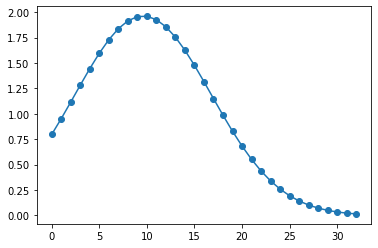

In [3]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')
plt.show()

## Boundary Condition

In [4]:
from numpy import cos, pi, sin, exp
u0L = 1.0#cos(0.0)*3*pi
u0R = 0.1 #cos(3*pi)*3*pi
print(f'u0L: {u0L}, u0R: {u0R}')
run.BC_setup(u0L, u0R)

u0L: 1.0, u0R: 0.1


## $m_{true}$

Text(0.5, 1.0, 'Coefficient')

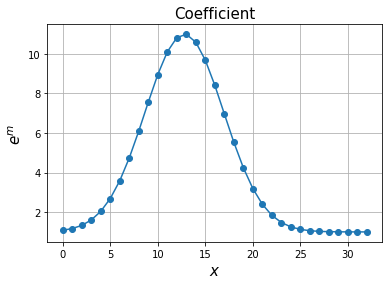

In [5]:
# The true and inverted parameter
peak_loc = 0.4
gauss_var = 30
mtrue_expression_str = f'std::log(1.+ 10.*std::exp(-pow(x[0] - {peak_loc}, 2) * {gauss_var}))'
# mtrue_expression_str = 'std::x[0]*sin(x[0])'
mtrue_expression = dl.Expression(mtrue_expression_str, degree=5)
mtrue = m =  dl.interpolate(mtrue_expression,run.Vm)
run.mtrue_setup(mtrue)

# mtrue = dl.Function(Vm)
# mtrue.vector().set_local(m_func[::-1,...])
plt.plot(np.exp(mtrue.compute_vertex_values()), 'o-')
plt.grid()
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$e^{m}$', fontsize=15)
plt.title('Coefficient',fontsize=15)

## Setup Data

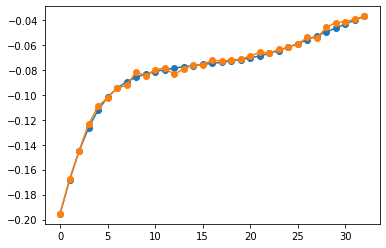

In [6]:
np.random.seed(0)
noise_level = 0.01
ud, goal_A, goal_b = run.fwd_solve(m)
utrue_array = ud.compute_vertex_values()
from utils.general import apply_noise
apply_noise(noise_level, ud, goal_A)
run.data_setup(ud_array = ud.compute_vertex_values(),normalize = False)

plt.plot(utrue_array, 'o-')
plt.plot(run.ud.compute_vertex_values(), 'o-')
plt.show()

## Initial Guess and Initial Solution

In [8]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(mtrue)

u,_,_ = run.fwd_solve(m)
print('left side: ',(u.compute_vertex_values()[1] - u.compute_vertex_values()[0])/run.mesh.hmax() * np.exp(m.compute_vertex_values()[0]) )
print('right side: ',(u.compute_vertex_values()[-1] - u.compute_vertex_values()[-2])/run.mesh.hmax() * np.exp(m.compute_vertex_values()[-1]) )
print('true left side: ', u0L)
print('true right side: ', u0R)

left side:  0.974941164642372
right side:  0.10007059749561598
true left side:  1.0
true right side:  0.1


## Optimization Loop

In [8]:
tol = 1e-11
c = 1e-4
maxiter=100
m, u = run.opt_loop(m, tol, c, maxiter)

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     5.98540e-05   1.19708e-04   4.13175e-10   2.00753e-02   7.43249e-04   1.00e+00   5.000e-01
 2     1     4.58907e-05   9.17811e-05   2.46870e-10   4.76119e-03   1.75278e-04   1.00e+00   4.856e-01
 3     3     6.77250e-06   1.30168e-05   5.28165e-07   7.48885e-03   1.28996e-04   1.00e+00   4.166e-01
 4     1     5.34642e-06   1.01636e-05   5.29241e-07   1.73473e-03   6.90315e-05   1.00e+00   3.048e-01
 5     3     1.62463e-06   2.35646e-06   8.92806e-07   2.69254e-03   6.04510e-05   1.00e+00   2.852e-01
 6     2     1.59435e-06   2.29607e-06   8.92621e-07   2.42948e-04   8.47685e-06   1.00e+00   1.068e-01
 7    15     1.40149e-06   1.77679e-06   1.02618e-06   6.12673e-04   5.34385e-06   1.00e+00   8.479e-02
 8     2     1.39325e-06   1.76057e-06   1.02592e-06   1.27480e-04   3.40266e-06   1.00e+00   6.766e-02
 9    16     1.38433e-06   1.72091e-06   1.04776e-06   1.26843e-04   8.

## Plot Results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


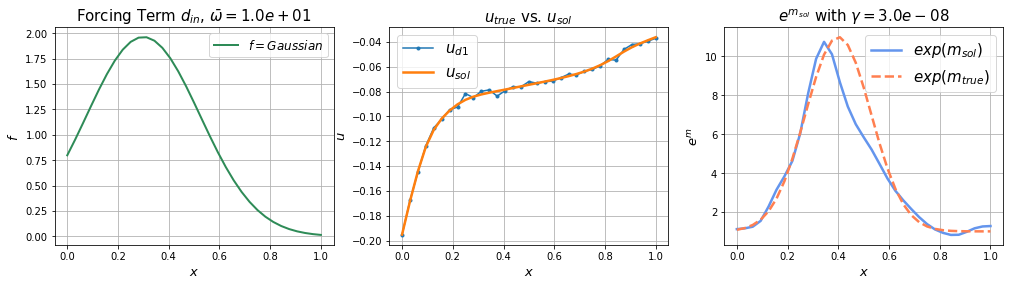

In [9]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

ax[0].plot(x, f.compute_vertex_values(run.mesh), 'seagreen', label=r'$f=Gaussian$', linewidth=2)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$f$', fontsize=13)
ax[0].set_title(r'Forcing Term $d_{in}$, $\bar{\omega} = '+f'{run.omega:1.1e}$', fontsize=15)
# ax[0].legend()
ax[0].legend(prop={'size':12})

ax[1].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
# ax[1].plot(x, run.ud.compute_vertex_values()-0.02 , 'o-',label=r'$u_{d2}$', markersize=3)
ax[1].plot(x, u.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$u$', fontsize=13)
ax[1].set_title(r'$u_{true}$ vs. $u_{sol}$', fontsize=15)
ax[1].legend(prop={'size':15})

text = ax[2].yaxis.get_offset_text()
text.set_fontsize(8)
ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
ax[2].plot(x, np.exp(mtrue.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[2].grid('on')
ax[2].set_xlabel(r'$x$', fontsize=13)
ax[2].set_ylabel(r'$e^m$', fontsize=13)
ax[2].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[2].legend(prop={'size':15})

# plt.savefig(f'./log/img/helm_NB_synth.eps', format='eps',dpi=250)
plt.show()

# Dirichlet Boundary Condition

In [1]:
from helm_eq import single_data_run

import dolfin as dl
import ufl
import numpy as np
import matplotlib.pyplot as plt


## Initialization

In [2]:
nx = 32
a,b = 0,1
bc_type = 'DBC'
omega = 10
oce_val = 0.0
gamma =3e-5

run = single_data_run(nx, a, b, bc_type, omega, oce_val, normalized_mean=oce_val)
run.misfit_reg_setup(gamma)

a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx+self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx'
a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
run.state_adj_str_setup(a_state_str, L_state_str, a_adj_str, L_adj_str)

## Forcing Term

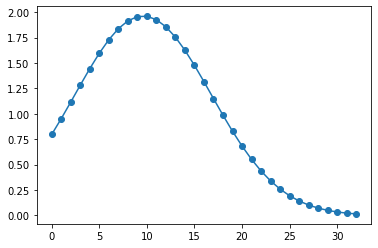

In [3]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')

## Boundary Condition

In [4]:
from numpy import cos, pi, sin, exp
u0L = 0.0#cos(0.0)*3*pi
u0R = 1.0 #cos(3*pi)*3*pi
print(f'u0L: {u0L}, u0R: {u0R}')
run.BC_setup(u0L, u0R)

u0L: 0.0, u0R: 1.0


## $m_{true}$

Text(0.5, 1.0, 'Coefficient')

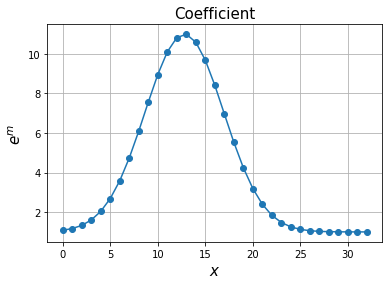

In [5]:
# The true and inverted parameter
peak_loc = 0.4
gauss_var = 30
mtrue_expression_str = f'std::log(1.+ 10.*std::exp(-pow(x[0] - {peak_loc}, 2) * {gauss_var}))'
# mtrue_expression_str = 'std::x[0]*sin(x[0])'
mtrue_expression = dl.Expression(mtrue_expression_str, degree=5)
mtrue = m =  dl.interpolate(mtrue_expression,run.Vm)
run.mtrue_setup(mtrue)

# mtrue = dl.Function(Vm)
# mtrue.vector().set_local(m_func[::-1,...])
plt.plot(np.exp(mtrue.compute_vertex_values()), 'o-')
plt.grid()
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$e^{m}$', fontsize=15)
plt.title('Coefficient',fontsize=15)

## Setup Data

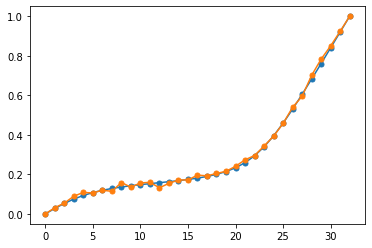

In [6]:
np.random.seed(0)
noise_level = 0.01
ud, goal_A, goal_b = run.fwd_solve(m)
utrue_array = ud.compute_vertex_values()
from utils.general import apply_noise
apply_noise(noise_level, ud, goal_A)
run.data_setup(ud_array = ud.compute_vertex_values())

plt.plot(utrue_array, 'o-',markersize=5)
plt.plot(run.ud.compute_vertex_values(), 'o-',markersize=5)
plt.show()

## Initial Guess and Initial Solution

In [7]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(mtrue)
# m = mtrue

u,_,_ = run.fwd_solve(m)
print(u.compute_vertex_values()[0])
print(u.compute_vertex_values()[-1])

0.0
1.0


## Optimization Loop

In [8]:
tol = 1e-9
c = 1e-4
maxiter=100
m, u = run.opt_loop(m, tol, c, maxiter)

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     1.75362e-03   3.48909e-03   1.81405e-05   1.15103e-01   3.37827e-02   1.00e+00   5.000e-01
 2     2     7.85145e-04   1.40428e-03   1.66010e-04   4.57876e-02   8.44484e-03   1.00e+00   5.000e-01
 3     1     6.64292e-04   1.17679e-03   1.51790e-04   1.54948e-02   5.52185e-03   1.00e+00   4.043e-01
 4     2     3.56893e-04   3.03443e-04   4.10344e-04   2.50671e-02   2.80898e-03   1.00e+00   2.884e-01
 5     2     3.43724e-04   2.66141e-04   4.21306e-04   5.03947e-03   9.47733e-04   1.00e+00   1.675e-01
 6     4     3.32006e-04   2.11172e-04   4.52840e-04   4.84633e-03   4.08099e-04   1.00e+00   1.099e-01
 7     4     3.31946e-04   2.13801e-04   4.50091e-04   3.36969e-04   3.73623e-05   1.00e+00   3.326e-02
 8     5     3.31943e-04   2.13476e-04   4.50409e-04   7.92547e-05   8.92979e-06   1.00e+00   1.626e-02
 9     7     3.31942e-04   2.13432e-04   4.50453e-04   5.64288e-06   7.

## Plotting Results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


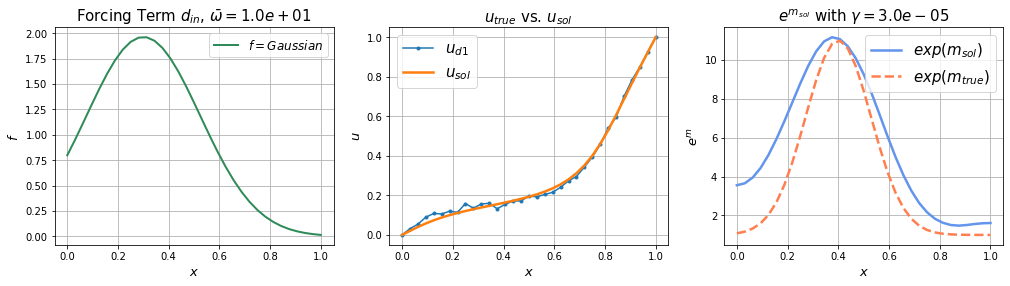

In [11]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

ax[0].plot(x, f.compute_vertex_values(run.mesh), 'seagreen', label=r'$f=Gaussian$', linewidth=2)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$f$', fontsize=13)
ax[0].set_title(r'Forcing Term $d_{in}$, $\bar{\omega} = '+f'{run.omega:1.1e}$', fontsize=15)
# ax[0].legend()
ax[0].legend(prop={'size':12})

ax[1].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
# ax[1].plot(x, run.ud.compute_vertex_values()-0.02 , 'o-',label=r'$u_{d2}$', markersize=3)
ax[1].plot(x, u.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$u$', fontsize=13)
ax[1].set_title(r'$u_{true}$ vs. $u_{sol}$', fontsize=15)
ax[1].legend(prop={'size':15})

text = ax[2].yaxis.get_offset_text()
text.set_fontsize(8)
ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
ax[2].plot(x, np.exp(mtrue.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[2].grid('on')
ax[2].set_xlabel(r'$x$', fontsize=13)
ax[2].set_ylabel(r'$e^m$', fontsize=13)
ax[2].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[2].legend(prop={'size':15})

# plt.savefig(f'./log/img/helm_DB_synth.eps', format='eps',dpi=250)
plt.show()

# Dual Data Problem

In [1]:
from helm_eq import dual_data_run
import dolfin as dl
import ufl
import numpy as np
import matplotlib.pyplot as plt

## Initialization

In [30]:
nx = 32
a,b = 0,1
omega = 10
oce_val1 = 0.0
oce_val2 = 0.0
gamma =3e-8

beta1 = 0.0
beta2 = 1.0

run = dual_data_run(nx, a, b, gamma, omega, omega, oce_val1, oce_val2, normalized_mean1=oce_val1,normalized_mean2=oce_val2, beta1=beta1, beta2 = beta2)
x = run.mesh.coordinates()

In [31]:
a1_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val1 * self.u_trial * self.u_test * ufl.dx'
L1_state_str = 'self.f * self.omega_val1 * self.u_oce_val1 * self.u_test * ufl.dx'
a1_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val1 * self.p_trial * self.p_test * ufl.dx'
L1_adj_str = '-ufl.inner(u1 - self.ud1, self.p_test) * ufl.dx'

a2_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val2 * self.u_trial * self.u_test * ufl.dx'
L2_state_str = 'self.f * self.omega_val2 * self.u_oce_val2 * self.u_test * ufl.dx  + self.j1 * self.u_test * self.ds(1) - self.j0 * self.u_test * self.ds(0)'
a2_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val2 * self.p_trial * self.p_test * ufl.dx'
L2_adj_str = '-ufl.inner(u2 - self.ud2, self.p_test) * ufl.dx'

run.state_adj_str_setup(a1_state_str, L1_state_str,a1_adj_str, L1_adj_str,  a2_state_str, L2_state_str,  a2_adj_str, L2_adj_str)

## Forcing Term

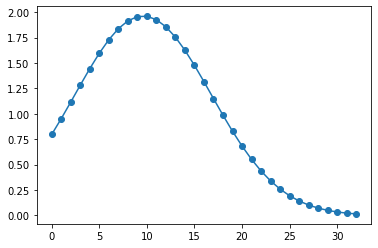

In [32]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')

## Boundary Condition

In [33]:
from numpy import cos, pi, sin, exp
u1L_D = 0.0#cos(0.0)*3*pi
u1R_D = 1.0 #cos(3*pi)*3*pi
u2L_N = 1.0
u2R_N = 0.1
print(f'Dirichlet_L: {u1L_D}, Dirichlet_R: {u1R_D}, NBC_L: {u2L_N}, NBC_R: {u2R_N}')
run.BC_setup(u1L_D, u1R_D, u2L_N, u2R_N)

Dirichlet_L: 0.0, Dirichlet_R: 1.0, NBC_L: 1.0, NBC_R: 0.1


## $m_{true}$

Text(0.5, 1.0, 'Coefficient')

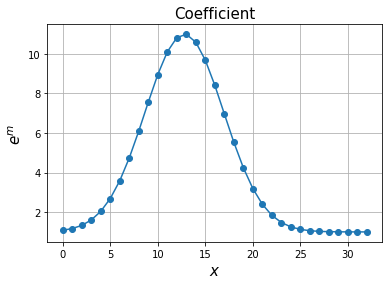

In [34]:
# The true and inverted parameter
peak_loc = 0.4
gauss_var = 30
mtrue_expression_str = f'std::log(1.+ 10.*std::exp(-pow(x[0] - {peak_loc}, 2) * {gauss_var}))'
# mtrue_expression_str = 'std::x[0]*sin(x[0])'
mtrue_expression = dl.Expression(mtrue_expression_str, degree=5)
mtrue = m =  dl.interpolate(mtrue_expression,run.Vm)
run.mtrue_setup(mtrue)

# mtrue = dl.Function(Vm)
# mtrue.vector().set_local(m_func[::-1,...])
plt.plot(np.exp(mtrue.compute_vertex_values()), 'o-')
plt.grid()
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$e^{m}$', fontsize=15)
plt.title('Coefficient',fontsize=15)

## Setup Data

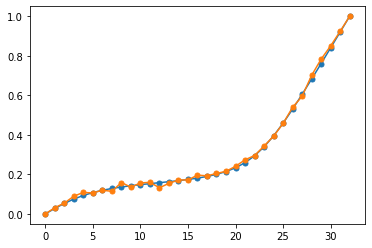

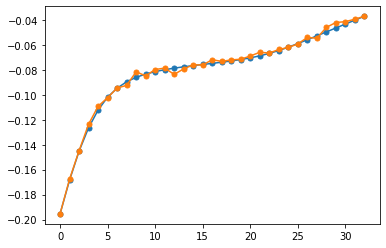

In [35]:

noise_level = 0.01
ud1, ud2, goal_A1, goal_b1, goal_A2, goal_b2 = run.fwd_solve(m)
utrue1_array = ud1.compute_vertex_values()
utrue2_array = ud2.compute_vertex_values()
from utils.general import apply_noise
np.random.seed(0)
apply_noise(noise_level, ud1, goal_A1)
np.random.seed(0)
apply_noise(noise_level, ud2, goal_A2)
run.data_setup(ud1.compute_vertex_values(), ud2.compute_vertex_values(),normalize=False)

plt.plot(utrue1_array, 'o-',markersize=5)
plt.plot(run.ud1.compute_vertex_values(), 'o-',markersize=5)
plt.show()
plt.plot(utrue2_array, 'o-',markersize=5)
plt.plot(run.ud2.compute_vertex_values(), 'o-',markersize=5)
plt.show()

## Initial Guess and Initial Solution

In [36]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(mtrue)
# m = mtrue

u1,u2,_,_,_,_ = run.fwd_solve(m)
print(u1.compute_vertex_values()[0])
print(u1.compute_vertex_values()[-1])
print((u2.compute_vertex_values()[1] - u2.compute_vertex_values()[0])/run.mesh.hmax())
print((u2.compute_vertex_values()[-1] - u2.compute_vertex_values()[-2])/run.mesh.hmax())

0.0
1.0
0.487470582321186
0.05003529874780799


## Optimization Loop

In [37]:
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%Y%m%d-%H%M%S")
print(dt_string)

20230906-132253


In [38]:
tol = 1e-11
c = 1e-4
maxiter=100
m, u1, u2 = run.opt_loop(m, tol, c, maxiter)

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     5.98540e-05   1.19708e-04   4.13175e-10   2.00753e-02   7.43249e-04   1.00e+00   5.000e-01
 2     1     4.58907e-05   9.17811e-05   2.46870e-10   4.76119e-03   1.75278e-04   1.00e+00   4.856e-01
 3     3     6.77250e-06   1.30168e-05   5.28165e-07   7.48885e-03   1.28996e-04   1.00e+00   4.166e-01
 4     1     5.34642e-06   1.01636e-05   5.29241e-07   1.73473e-03   6.90315e-05   1.00e+00   3.048e-01
 5     3     1.62463e-06   2.35646e-06   8.92806e-07   2.69254e-03   6.04510e-05   1.00e+00   2.852e-01
 6     2     1.59435e-06   2.29607e-06   8.92621e-07   2.42948e-04   8.47685e-06   1.00e+00   1.068e-01
 7    15     1.40149e-06   1.77679e-06   1.02618e-06   6.12673e-04   5.34385e-06   1.00e+00   8.479e-02
 8     2     1.39325e-06   1.76057e-06   1.02592e-06   1.27480e-04   3.40266e-06   1.00e+00   6.766e-02
 9    16     1.38433e-06   1.72091e-06   1.04776e-06   1.26843e-04   8.

## Plotting Results

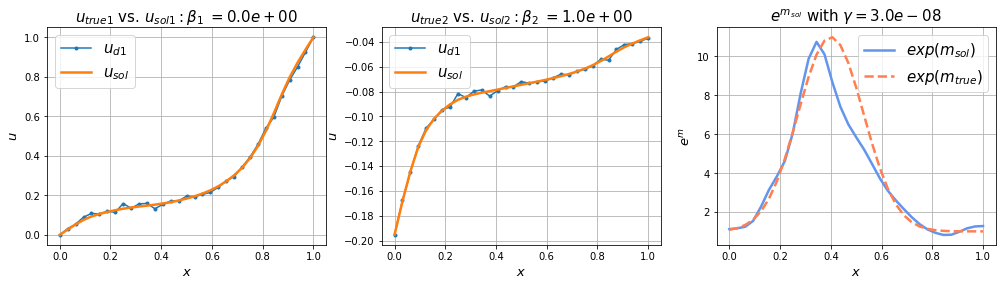

In [39]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

ax[0].plot(x, run.ud1.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
ax[0].plot(x, u1.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$u$', fontsize=13)
ax[0].set_title(r'$u_{true1}$ vs. $u_{sol1}: \beta_1$' + f' $ = {beta1:1.1e}$', fontsize=15)
ax[0].legend(prop={'size':15})

ax[1].plot(x, run.ud2.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
ax[1].plot(x, u2.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$u$', fontsize=13)
ax[1].set_title(r'$u_{true2}$ vs. $u_{sol2}: \beta_2$' + f' $ = {beta2:1.1e}$', fontsize=15)
ax[1].legend(prop={'size':15})

text = ax[2].yaxis.get_offset_text()
text.set_fontsize(8)
ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
ax[2].plot(x, np.exp(mtrue.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[2].grid('on')
ax[2].set_xlabel(r'$x$', fontsize=13)
ax[2].set_ylabel(r'$e^m$', fontsize=13)
ax[2].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[2].legend(prop={'size':15})

# plt.savefig(f'./log/img/dual_helm_synth_{beta1:1.1f}_{beta2:1.1f}.eps', format='eps',dpi=250)
plt.show()

# Construct a Dual Problem

## single data DBC or NBC

In [75]:
from helm_eq import single_data_run
import dolfin as dl
import ufl
import numpy as np
import matplotlib.pyplot as plt

In [76]:
nx = 32
a,b = 0,1
bc_type = 'DBC'
omega = 1.0
oce_val = 1.0
gamma =1.043e-4 if bc_type == 'DBC' else 1.6e-3
gamma = 1.0e-4
run = single_data_run(nx, a, b, bc_type, omega, oce_val, normalized_mean=0.0)
run.misfit_reg_setup(gamma)

if bc_type == 'DBC':
    a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx+self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
    L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx + self.g * self.u_test * ufl.dx'
    a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
    L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
elif bc_type == 'NBC':
    a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
    L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx + self.g * self.u_test * ufl.dx  + self.j1 * self.u_test * self.ds(1) - self.j0 * self.u_test * self.ds(0)'
    a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
    L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
run.state_adj_str_setup(a_state_str, L_state_str, a_adj_str, L_adj_str)

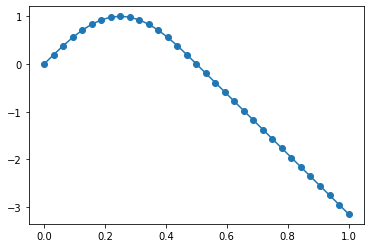

In [77]:
from numpy import cos, sin, exp, pi
x = np.linspace(a,b,nx+1)

y = sin(2* pi * x)
y_lin = -2 * pi * x +  pi
y1 = y.copy()
y2 = y.copy()
if bc_type == 'DBC':
    y1[x>=0.5] = y_lin[x>=0.5]
elif bc_type == 'NBC':
    y1[x<=0.5] = y_lin[x<=0.5]
else:
    raise ValueError(f'Unknown BC type: {bc_type}')
dy1 = np.gradient(y1,x,edge_order=2)

# plt.plot(x, np.gradient(y1,x), 'o')
plt.plot(x, y1, 'o-')
# plt.plot(x, dy1)
# plt.plot(x, cos(x*pi*2)* 2 * pi)
# plt.plot(x, y2, 'o')
# plt.plot(x,y_lin)

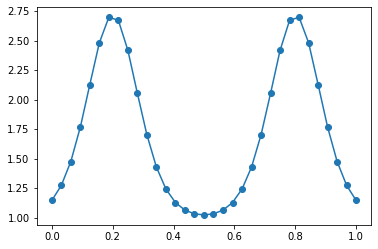

In [78]:
def gaussian(x, mean, std):
    return np.exp(-np.power(x - mean, 2.) / (2 * np.power(std, 2.)))

mtrue_array = gaussian(x, 0.2, 0.1) + gaussian(x, 0.8, 0.1)
# mtrue_array = np.log(1 + 10 * gaussian(x, 0.4, 1/np.sqrt(60)))
# mtrue_array = np.zeros_like(x)
m_true = dl.Function(run.Vm)
m_true.vector().set_local(mtrue_array[::-1])
run.mtrue_setup(m_true)
plt.plot(x, np.exp(run.mtrue.compute_vertex_values()), 'o-')


### Setup Forcing

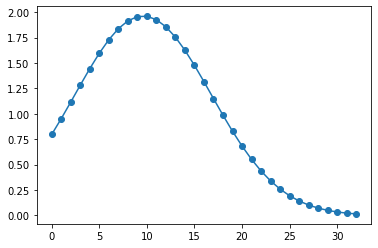

In [79]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
forcing_array = f.compute_vertex_values()
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')

### Setup BC

In [80]:
uL = y1[0] if bc_type == 'DBC' else dy1[0] * np.exp(mtrue_array[0])
uR = y1[-1] if bc_type == 'DBC' else dy1[-1] * np.exp(mtrue_array[-1])
print(f'uL: {uL}, uR: {uR}')
run.BC_setup(uL, uR)

uL: 0.0, uR: -3.141592653589793


### Set up extra Forcing

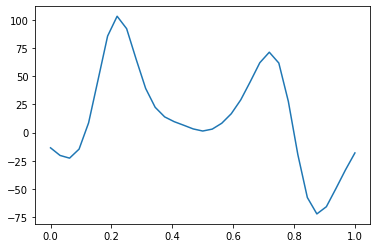

In [81]:
g_array = - np.gradient( np.exp(mtrue_array) * np.gradient(y1, x, edge_order=2) , x, edge_order=2) \
            + forcing_array * omega * (y1 - oce_val)

g = dl.Function(run.Vu)
g.vector().set_local(g_array[::-1])
run.extra_f_setup(g = g)

plt.plot(x,run.g.compute_vertex_values())
plt.show()

### Setup Data


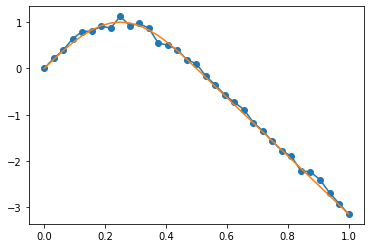

In [82]:
noise_level = 0.02
ud, goal_A, goal_b = run.fwd_solve(m_true)
utrue_array = ud.compute_vertex_values()
from utils.general import apply_noise
np.random.seed(0)
apply_noise(noise_level, ud, goal_A)
run.data_setup(ud_array = ud.compute_vertex_values(),normalize = False)

plt.plot(x, run.ud.compute_vertex_values(), 'o-')
plt.plot(x, y1)

### Initial Guess

0.0
-3.141592653589793
0.0 -3.141592653589793


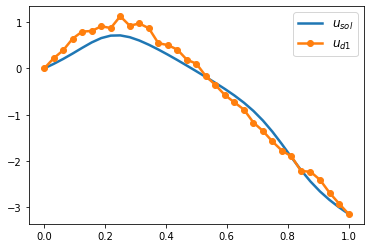

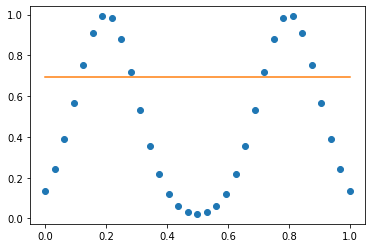

In [83]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(mtrue)
# m = mtrue

u,_,_ = run.fwd_solve(m)
if bc_type == 'DBC':
    print(u.compute_vertex_values()[0])
    print(u.compute_vertex_values()[-1])
    print(y1[0], y1[-1])
elif bc_type == 'NBC':
    print((u.compute_vertex_values()[1] - u.compute_vertex_values()[0])/run.mesh.hmax() * np.exp(mtrue_array[0]))
    print((u.compute_vertex_values()[-1] - u.compute_vertex_values()[-2])/run.mesh.hmax() * np.exp(mtrue_array[-1]))
    print(uL, uR)

plt.plot(x,u.compute_vertex_values(), label=r'$u_{sol}$',linewidth=2.5)
plt.plot(x,run.ud.compute_vertex_values(),'o-', label=r'$u_{d1}$',linewidth=2.5)
plt.legend(prop={'size':12})
plt.show()

plt.plot(x,mtrue_array, 'o')
plt.plot(x, m.compute_vertex_values())

### Optimization Loop

In [84]:
tol = 1e-11
c = 1e-4
maxiter=100
m, u = run.opt_loop(m, tol, c, maxiter)

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     1.71564e-02   3.43128e-02   7.18179e-09   9.66011e-02   1.28326e-01   1.00e+00   5.000e-01
 2     2     6.07091e-03   1.20883e-02   5.35331e-05   1.49700e-01   1.40638e-01   1.00e+00   5.000e-01
 3     1     6.00338e-03   1.19533e-02   5.34718e-05   1.16253e-02   4.42881e-02   1.00e+00   5.000e-01
 4     5     2.63307e-03   4.39956e-03   8.66586e-04   8.79582e-02   3.95418e-02   1.00e+00   5.000e-01
 5     1     2.12617e-03   3.38540e-03   8.66938e-04   3.18451e-02   6.02514e-02   1.00e+00   5.000e-01
 6     2     2.04985e-03   3.22728e-03   8.72426e-04   1.23924e-02   1.59699e-02   1.00e+00   3.528e-01
 7     7     1.70748e-03   2.13339e-03   1.28156e-03   2.65454e-02   1.02310e-02   1.00e+00   2.824e-01
 8     1     1.69545e-03   2.10938e-03   1.28152e-03   4.89679e-03   9.01950e-03   1.00e+00   2.651e-01
 9     9     1.66647e-03   2.02144e-03   1.31150e-03   7.66200e-03   2.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


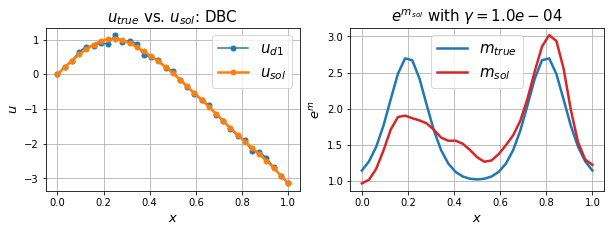

In [85]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,3),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

# ax[0].plot(x, f.compute_vertex_values(run.mesh), 'seagreen', label=r'$f=Gaussian$', linewidth=2)
# ax[0].grid('on')
# ax[0].set_xlabel(r'$x$', fontsize=13)
# ax[0].set_ylabel(r'$f$', fontsize=13)
# ax[0].set_title(r'Forcing Term $d_{in}$, $\bar{\omega} = '+f'{run.omega:1.1e}$', fontsize=15)
# # ax[0].legend()
# ax[0].legend(prop={'size':12})

if bc_type == 'DBC':
    ax[0].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=5)
elif bc_type == 'NBC':
    ax[0].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{d2}$', markersize=5)
else:
    raise ValueError(f'Unknown BC type: {bc_type}')
# ax[1].plot(x, run.ud.compute_vertex_values()-0.02 , 'o-',label=r'$u_{d2}$', markersize=3)
ax[0].plot(x, u.compute_vertex_values(), 'o-', markersize=5, label=r'$u_{sol}$',linewidth=2.5)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$u$', fontsize=13)
ax[0].set_title(r'$u_{true}$ vs. $u_{sol}$: '+ f'{bc_type}', fontsize=15)
ax[0].legend(prop={'size':15})

text = ax[1].yaxis.get_offset_text()
text.set_fontsize(8)
# ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
# ax[2].plot(x, np.exp(m_true.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[1].plot(x,np.exp(m_true.compute_vertex_values()), '-', label=r'$m_{true}$', linewidth=2.5,color = 'tab:blue')
ax[1].plot(x,np.exp(m.compute_vertex_values()), '-', label=r'$m_{sol}$', linewidth=2.5,color = 'tab:red')
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$e^m$', fontsize=13)
ax[1].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[1].legend(prop={'size':15})

# plt.savefig(f'./log/img/helm_DB_synth.eps', format='eps',dpi=250)
eps = True
if not eps:
    if bc_type == 'DBC':
        plt.savefig(f'./log/img/helm_DB_synth.png',dpi=250)
    elif bc_type == 'NBC':
        plt.savefig(f'./log/img/helm_NB_synth.png',dpi=250)
else:
    if bc_type == 'DBC':
        plt.savefig(f'./log/img/helm_DB_synth.eps',format='eps',dpi=250,bbox_inches='tight')
    elif bc_type == 'NBC':
        plt.savefig(f'./log/img/helm_NB_synth.eps',format='eps',dpi=250,bbox_inches='tight')
plt.show()

### Eigenvalue of Hess

In [89]:
k = run.nx
lmbda, evecs = run.eigenvalue_request(m, p=20)
if bc_type == 'DBC':
    DBC_eig = lmbda.copy()
elif bc_type == 'NBC':
    NBC_eig = lmbda.copy()
else:
    raise ValueError(f'Unknown BC type: {bc_type}')

# plt.plot(range(0,k+1), np.ones(k+1), '-r')
# plt.plot(range(0,k), lmbda, 'b*')
# if 'DBC_eig' in locals():
#     plt.plot(range(0,k), DBC_eig, '*', label='DBC Hess Eig')
# if 'NBC_eig' in locals():
#     plt.plot(range(0,k), NBC_eig, '*', label='NBC Hess Eig')
# plt.legend()
# plt.yscale('log')
# plt.xlabel('number')
# plt.ylabel('eigenvalue')

num DBC_eig (eig>1.0):  7


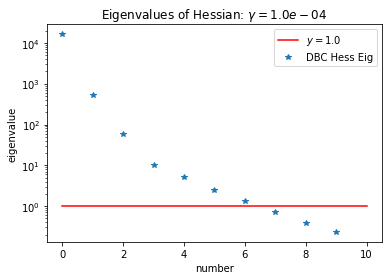

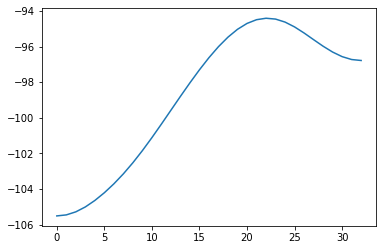

In [90]:
cutoff_num = 1.0
print(f'num DBC_eig (eig>{cutoff_num}): ', sum(DBC_eig-1>=cutoff_num))
# print(f'num NBC_eig (eig>{cutoff_num}): ', sum(NBC_eig-1>=cutoff_num))
# print(f'num dual_eig (eig>{cutoff_num}): ', sum(dual_eig-1>=cutoff_num))

k = 10
plt.plot(range(0,k+1), np.ones(k+1)*cutoff_num, '-r',label=f'$y={cutoff_num}$')
if 'DBC_eig' in locals():
    plt.plot(range(0,k), (DBC_eig-1)[:k], '*', label='DBC Hess Eig')
if 'NBC_eig' in locals():
    plt.plot(range(0,k), (NBC_eig-1)[:k], '*', label='NBC Hess Eig')
if 'dual_eig' in locals():
    plt.plot(range(0,k), (dual_eig-1)[:k], 'b*', label='Double Data Eig')
# plt.ylim([0.5,1.5])
plt.legend()
plt.yscale('log')
plt.xlabel('number')
plt.ylabel('eigenvalue')
plt.title(f'Eigenvalues of Hessian: $\gamma = {gamma:1.1e}$')
# plt.savefig('./log/img/eigenvalues_doubledata.eps', format='eps',dpi=250)
plt.show()

plt.plot(evecs[0])

In [ ]:
plt.plot(evecs[:,0])

## Double Data 

In [1]:
from helm_eq import dual_data_run
import dolfin as dl
import ufl
import numpy as np
import matplotlib.pyplot as plt

### Initialization


In [2]:
nx = 32
a,b = 0,1
omega = 1.0
oce_val = 0.0
gamma1 = 1.0e-4 #1.048e-4
gamma2 = 1.0e-4 #1.6e-3
print(f'gamma1   = {gamma1}, gamma2 = {gamma2}')
run = dual_data_run(nx,a,b,gamma1, gamma2, omega,omega,oce_val,oce_val, normalized_mean1=0.0, normalized_mean2=0.0)

beta1 = 0.5
beta2 = 0.5
run.misfit_reg_setup(beta1, beta2)

a1_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val1 * self.u_trial * self.u_test * ufl.dx'
L1_state_str = 'self.f * self.omega_val1 * self.u_oce_val1 * self.u_test * ufl.dx + self.g1 * self.u_test * ufl.dx'
a1_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val1 * self.p_trial * self.p_test * ufl.dx'
L1_adj_str = '-ufl.inner(u1 - self.ud1, self.p_test) * ufl.dx'

a2_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val2 * self.u_trial * self.u_test * ufl.dx'
L2_state_str = 'self.f * self.omega_val2 * self.u_oce_val2 * self.u_test * ufl.dx + self.g2 * self.u_test * ufl.dx  + self.j1 * self.u_test * self.ds(1) - self.j0 * self.u_test * self.ds(0)'
a2_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val2 * self.p_trial * self.p_test * ufl.dx'
L2_adj_str = '-ufl.inner(u2 - self.ud2, self.p_test) * ufl.dx'

run.state_adj_str_setup(a1_state_str, L1_state_str, a1_adj_str, L1_adj_str, a2_state_str, L2_state_str, a2_adj_str, L2_adj_str)

gamma1   = 0.0001, gamma2 = 0.0001


### Set up $u_{data}$ without noise

y1 mean: -1.3457248783335231e-17, y1 std: 1.3185742607495525
y2 mean: 1.682156097916904e-17, y2 std: 1.3185742607495528


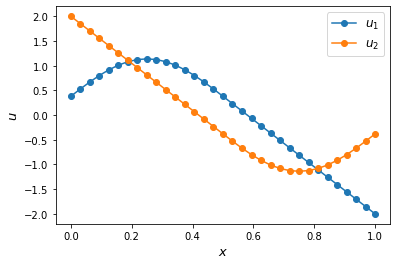

In [3]:
from numpy import cos, sin, exp, pi
x = np.linspace(a,b,nx+1)

y = sin(2* pi * x)
y_lin = -2 * pi * x +  pi
y1 = y.copy()
y2 = y.copy()

y1[x>=0.5] = y_lin[x>=0.5]
y2[x<=0.5] = y_lin[x<=0.5]


def normalize_u(u_array):
    mean = np.mean(u_array)
    std = np.std(u_array)
    return (u_array - mean) / std, mean, std

y1, y1_mean, y1_std = normalize_u(y1)
y2, y2_mean, y2_std = normalize_u(y2)

# run.u_oce1 = (run.u_oce1 - y1_mean) / y1_std
# run.u_oce_val1 = dl.Constant(f'{run.u_oce1}')
# run.u_oce2 = (run.u_oce2 - y2_mean) / y2_std
# run.u_oce_val2 = dl.Constant(f'{run.u_oce2}')

print(f'y1 mean: {y1.mean()}, y1 std: {y1_std}')
print(f'y2 mean: {y2.mean()}, y2 std: {y2_std}')

    
dy1 = np.gradient(y1,x,edge_order=2)
dy2 = np.gradient(y2,x,edge_order=2)

plt.plot(x, y1, 'o-', label=r'$u_1$')
plt.plot(x, y2, 'o-', label=r'$u_2$')
plt.legend(prop={'size':12})
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$u$', fontsize=13)
# plt.savefig('./log/img/double_data_setupt.eps', bbox_inches='tight',format='eps')
plt.show()

### Setup $m_{true}$

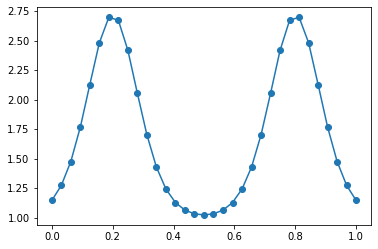

In [4]:
def gaussian(x, mean, std):
    return np.exp(-np.power(x - mean, 2.) / (2 * np.power(std, 2.)))

mtrue_array = gaussian(x, 0.2, 0.1) + gaussian(x, 0.8, 0.1)
# mtrue_array = np.log(1 + 10 * gaussian(x, 0.4, 1/np.sqrt(60)))
# mtrue_array = np.zeros_like(x)
m_true = dl.Function(run.Vm)
m_true.vector().set_local(mtrue_array[::-1])
run.mtrue_setup(m_true)
plt.plot(x, np.exp(run.mtrue.compute_vertex_values()), 'o-')


### Setup Forcing

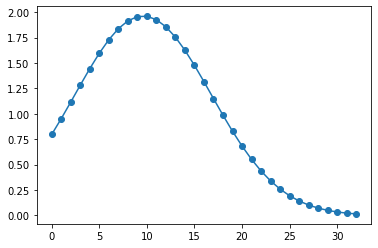

In [5]:

from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
forcing_array = f.compute_vertex_values()
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')

### BC setup

In [6]:
from numpy import cos, pi, sin, exp
u1L_D = y1[0]
u1R_D = y1[-1]
u2L_N = dy2[0] * np.exp(mtrue_array[0])
u2R_N = dy2[-1] * np.exp(mtrue_array[-1])
print(f'Dirichlet_L: {u1L_D}, Dirichlet_R: {u1R_D},')
print(f'NBC_L: {u2L_N}, NBC_R: {u2R_N}')
run.BC_setup(u1L_D, u1R_D, u2L_N, u2R_N)

Dirichlet_L: 0.38035497335598545, Dirichlet_R: -2.0022128858133064,
NBC_L: -5.455702010876427, NBC_R: 5.5248712770988275


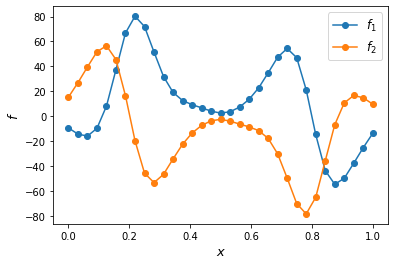

In [7]:
g1_array = - np.gradient( np.exp(mtrue_array) * np.gradient(y1, x, edge_order=2) , x, edge_order=2) \
            + forcing_array * omega * (y1 - oce_val)

g1 = dl.Function(run.Vu)
g1.vector().set_local(g1_array[::-1])

g2_array = - np.gradient( np.exp(mtrue_array) * np.gradient(y2, x, edge_order=2) , x, edge_order=2) \
            + forcing_array * omega * (y2 - oce_val)
g2 = dl.Function(run.Vu)
g2.vector().set_local(g2_array[::-1])
run.extra_f_setup(g1 = g1, g2 = g2)

plt.plot(x,run.g1.compute_vertex_values(),'o-',label=r'$f_1$')
plt.plot(x,run.g2.compute_vertex_values(),'o-',label=r'$f_2$')
plt.legend(prop={'size':12})
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$f$', fontsize=13)
# plt.savefig('./log/img/double_data_setupt_forcing.eps', bbox_inches='tight',format='eps')
plt.show()

-0.1367524594063987


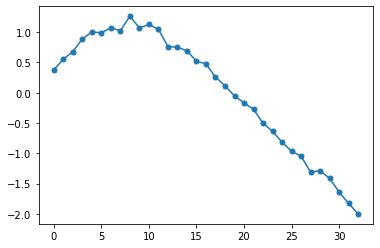

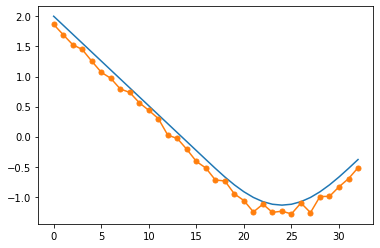

In [8]:
noise_level = 0.03

run.data_setup(y1, y2 ,normalize=False)
from utils.general import apply_noise
ud1, ud2, A1, b1, A2, b2 = run.fwd_solve(m_true)
np.random.seed(0)
apply_noise(noise_level, ud1, A1)
np.random.seed(1)
apply_noise(noise_level, ud2, A2)
run.data_setup(ud1.compute_vertex_values(), ud2.compute_vertex_values(), normalize=False)


# plt.plot(y1, '-',markersize=5)
print(np.mean(run.ud2.compute_vertex_values()))
plt.plot(run.ud1.compute_vertex_values(), 'o-',markersize=5)
plt.show()
plt.plot(y2, '-',markersize=5)
plt.plot(run.ud2.compute_vertex_values(), 'o-',markersize=5)
plt.show()

### Initial Guess

Text(0, 0.5, '$u_2$')

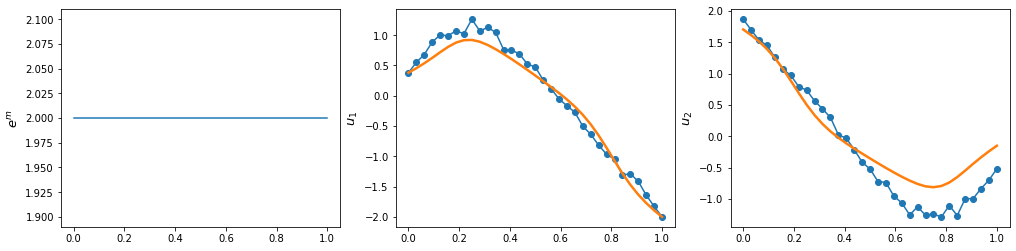

In [13]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(m_true)
u1,u2,_,_,_,_ = run.fwd_solve(m)
# print(u1.compute_vertex_values()[0])
# print(u1.compute_vertex_values()[-1])
# print((u2.compute_vertex_values()[1] - u2.compute_vertex_values()[0])/run.mesh.hmax())
# print((u2.compute_vertex_values()[-1] - u2.compute_vertex_values()[-2])/run.mesh.hmax())
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
ax[0].plot(x, np.exp(m.compute_vertex_values()))
ax[0].set_ylabel('$e^m$', fontsize=13)

ax[1].plot(x, run.ud1.compute_vertex_values(), '-o')
ax[1].plot(x, u1.compute_vertex_values(), linewidth=2.5)
ax[1].set_ylabel('$u_1$', fontsize=13)

ax[2].plot(x, run.ud2.compute_vertex_values(), '-o')
ax[2].plot(x, u2.compute_vertex_values(),linewidth=2.5)
ax[2].set_ylabel('$u_2$', fontsize=13)

0.28125


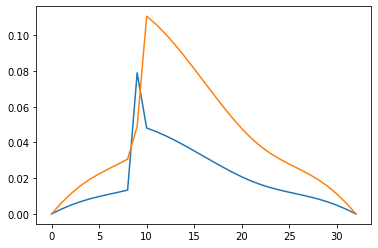

In [14]:
from utils.general import sensitivity_array
# mtrue_array = mtrue.compute_vertex_values()
utrue1_array = run.ud1.compute_vertex_values()
utrue2_array = run.ud2.compute_vertex_values()
sensitivity1 = sensitivity_array(mtrue_array, utrue1_array)
sensitivity2 = sensitivity_array(mtrue_array, utrue2_array)

# X = Y = np.arange(0,1,1/33)
# X, Y = np.meshgrid(X, Y)

# %matplotlib widget
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# surf = ax.plot_surface(X, Y, sensitivity, cmap="viridis")

%matplotlib inline
i = 24 # this is at x = 0.75
i = 9

print(i*run.mesh.hmax())
plt.plot(abs(sensitivity1[i,:]))
plt.plot(abs(sensitivity2[i,:]))

### Optimization Loop

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg


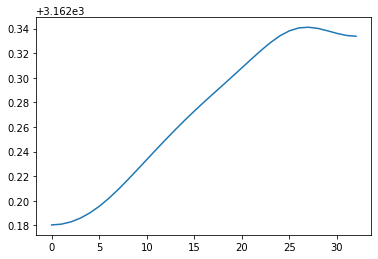

 1    209   2.65041e-02   5.30078e-02   3.24868e-07   2.01910e-01   1.73255e-01   1.00e+00   5.000e-01


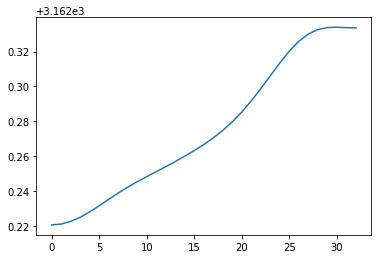

 2    105   2.45658e-02   4.91306e-02   1.03769e-06   1.90853e-01   2.23018e-01   1.00e+00   5.000e-01


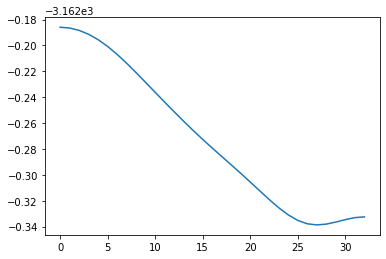

 3    105   2.16886e-02   4.33750e-02   2.23691e-06   1.59502e-01   1.48558e-01   1.00e+00   5.000e-01


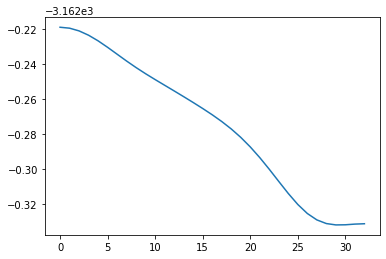

 4    105   2.06924e-02   4.13813e-02   3.51735e-06   1.57063e-01   1.86746e-01   1.00e+00   5.000e-01


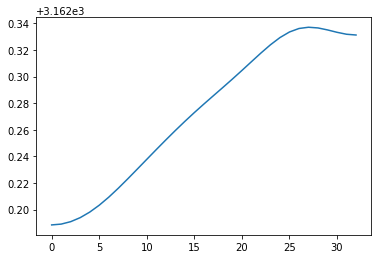

 5    105   1.89815e-02   3.79578e-02   5.18321e-06   1.37949e-01   1.31640e-01   1.00e+00   5.000e-01


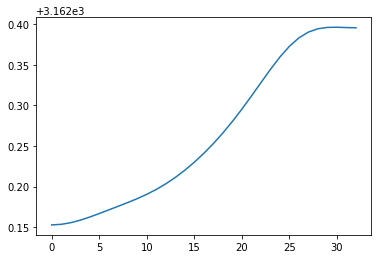

 6    105   1.72727e-02   3.45388e-02   6.58338e-06   1.33229e-01   1.64625e-01   1.00e+00   5.000e-01


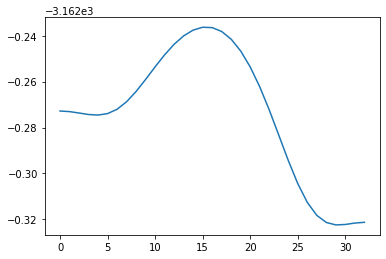

 7    105   1.40294e-02   2.80509e-02   7.82917e-06   1.26209e-01   1.14131e-01   5.00e-01   5.000e-01


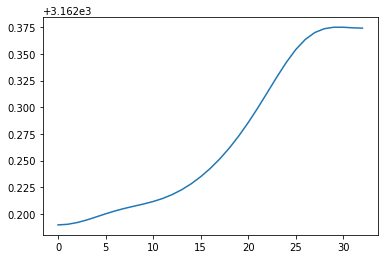

 8    106   1.34562e-02   2.67886e-02   1.23879e-04   1.18761e-01   1.07570e-01   1.00e+00   5.000e-01


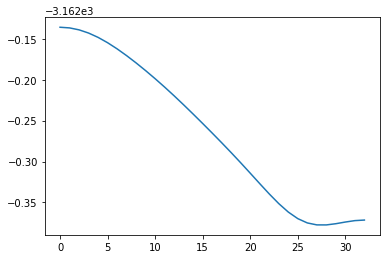

 9    106   9.44946e-03   1.88126e-02   8.62843e-05   1.41894e-01   9.96283e-02   1.00e+00   5.000e-01


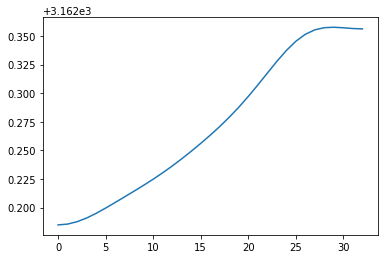

10    106   6.12593e-03   1.21146e-02   1.37281e-04   1.19489e-01   9.67647e-02   5.00e-01   5.000e-01


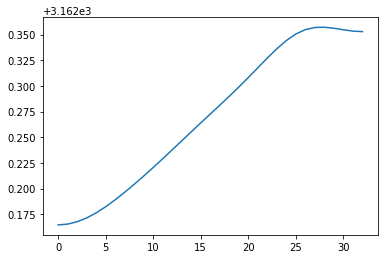

11    107   4.57197e-03   8.81853e-03   3.25412e-04   7.79342e-02   3.84583e-02   5.00e-01   4.711e-01


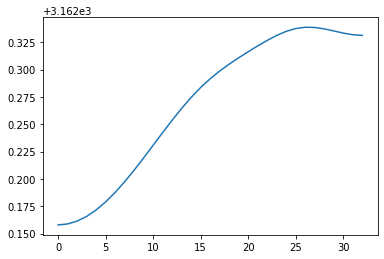

12    105   4.56141e-03   8.79827e-03   3.24555e-04   1.53297e-02   2.83819e-02   1.00e+00   4.047e-01


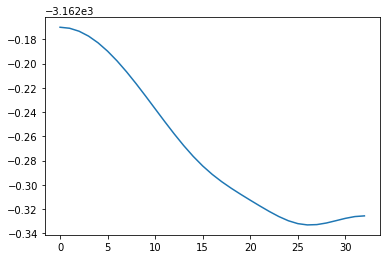

13    105   4.49365e-03   8.66297e-03   3.24325e-04   1.63871e-02   2.42686e-02   5.00e-01   3.743e-01


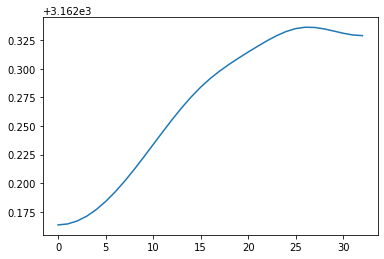

14    109   2.28297e-03   3.61084e-03   9.55093e-04   8.62136e-02   2.40274e-02   5.00e-01   3.724e-01


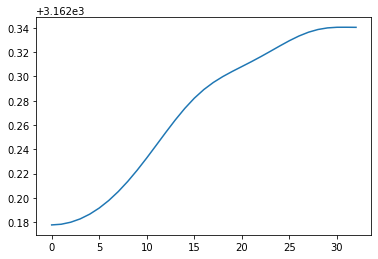

15    105   2.27830e-03   3.60092e-03   9.55670e-04   1.54071e-02   1.41606e-02   1.00e+00   2.859e-01


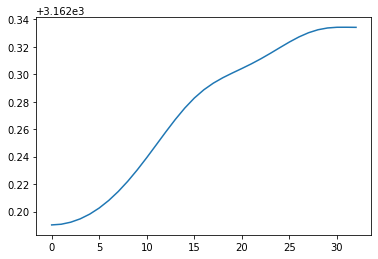

16    105   2.22134e-03   3.48653e-03   9.56136e-04   1.52086e-02   1.42514e-02   5.00e-01   2.868e-01


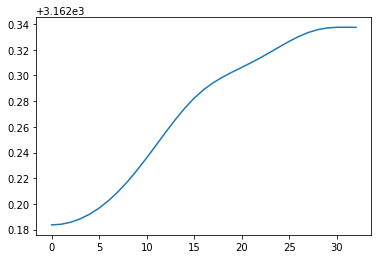

17    110   2.01104e-03   1.96928e-03   2.05279e-03   3.08700e-02   9.29733e-03   1.00e+00   2.317e-01


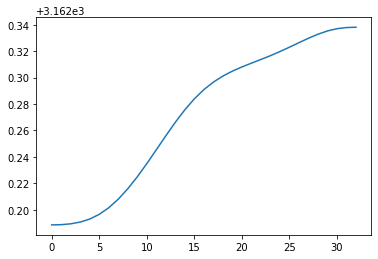

18    105   2.01045e-03   1.96889e-03   2.05202e-03   7.66126e-03   8.62860e-03   1.00e+00   2.232e-01


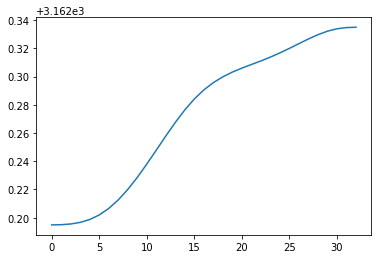

19    105   1.99547e-03   1.93917e-03   2.05177e-03   7.77132e-03   8.00170e-03   5.00e-01   2.149e-01


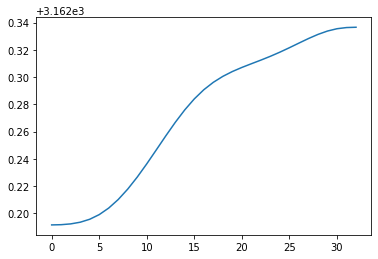

20    110   1.93979e-03   2.49050e-03   1.38908e-03   2.31275e-02   6.35382e-03   1.00e+00   1.915e-01


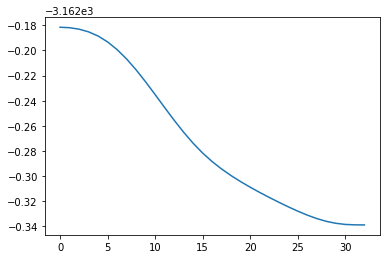

21    105   1.93954e-03   2.48965e-03   1.38944e-03   5.16540e-03   5.89267e-03   1.00e+00   1.844e-01


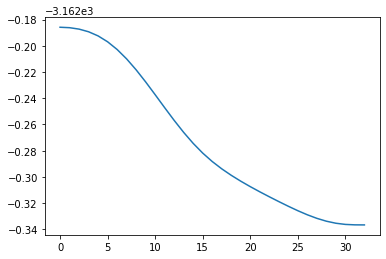

22    105   1.93274e-03   2.47581e-03   1.38968e-03   5.22122e-03   6.12502e-03   5.00e-01   1.880e-01


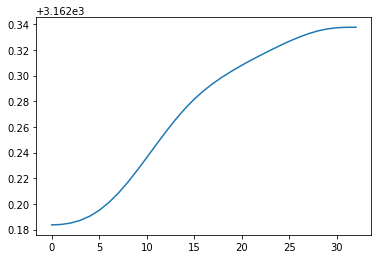

23    110   1.89571e-03   1.90164e-03   1.88978e-03   1.78874e-02   4.81710e-03   1.00e+00   1.667e-01


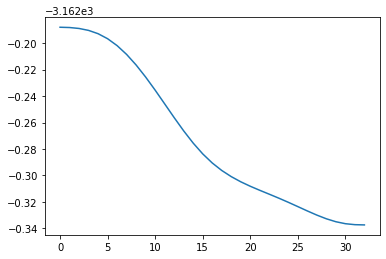

24    105   1.89567e-03   1.90201e-03   1.88932e-03   2.94717e-03   4.37809e-03   1.00e+00   1.590e-01


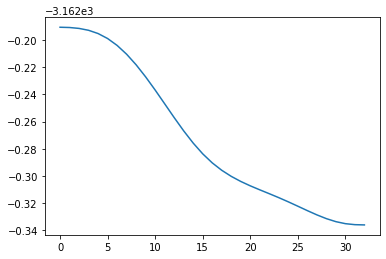

25    105   1.89333e-03   1.89752e-03   1.88915e-03   3.05779e-03   4.03816e-03   5.00e-01   1.527e-01


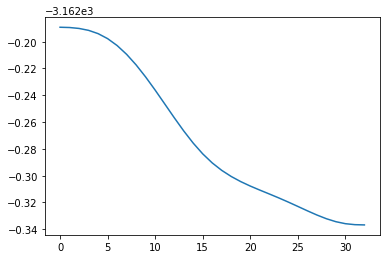

26    110   1.87245e-03   2.23663e-03   1.50828e-03   1.35724e-02   3.67523e-03   1.00e+00   1.456e-01


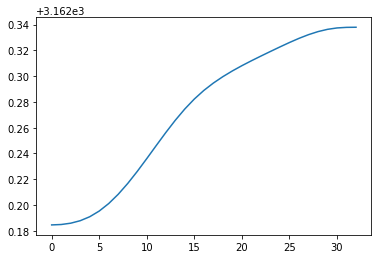

27    107   1.86305e-03   2.00498e-03   1.72111e-03   9.88425e-03   3.08064e-03   1.00e+00   1.333e-01


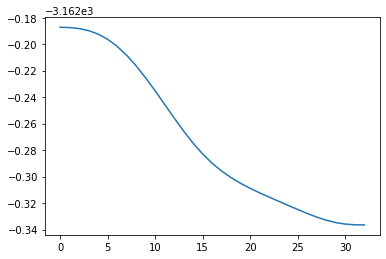

28    107   1.85899e-03   2.01987e-03   1.69812e-03   8.86585e-03   3.24595e-03   1.00e+00   1.369e-01


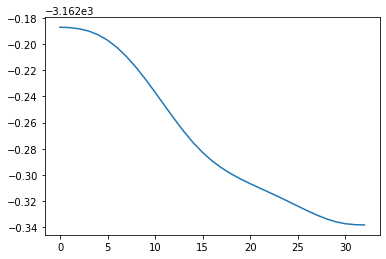

29    107   1.85549e-03   2.03167e-03   1.67932e-03   8.18604e-03   3.33325e-03   1.00e+00   1.387e-01


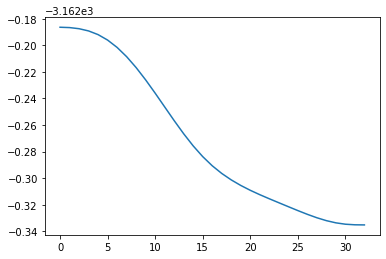

30    109   1.85230e-03   2.03289e-03   1.67170e-03   7.48506e-03   3.09138e-03   1.00e+00   1.336e-01


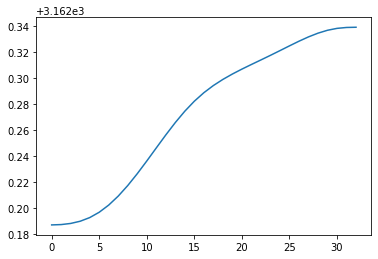

31    107   1.85113e-03   2.01977e-03   1.68250e-03   6.04732e-03   2.96009e-03   1.00e+00   1.307e-01


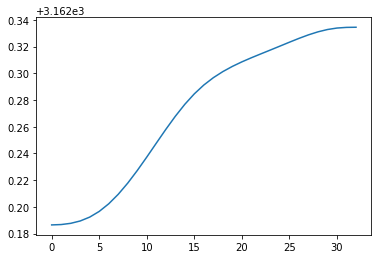

32    107   1.85001e-03   2.03982e-03   1.66019e-03   6.43002e-03   2.94279e-03   1.00e+00   1.303e-01


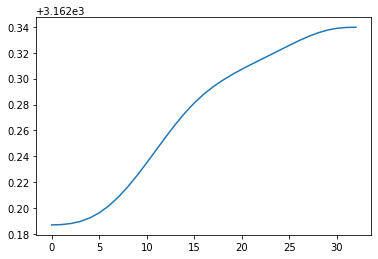

33    107   1.84930e-03   2.01720e-03   1.68140e-03   6.12202e-03   2.85225e-03   1.00e+00   1.283e-01


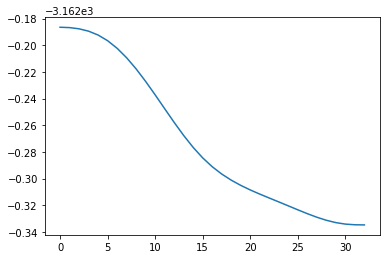

34    107   1.84839e-03   2.03574e-03   1.66105e-03   5.86083e-03   2.77022e-03   1.00e+00   1.264e-01


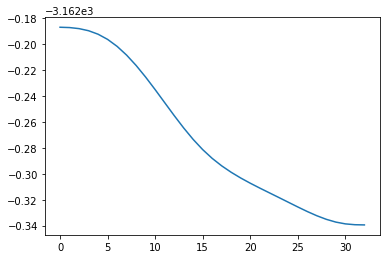

35    107   1.84786e-03   2.01520e-03   1.68051e-03   5.58694e-03   2.68688e-03   1.00e+00   1.245e-01


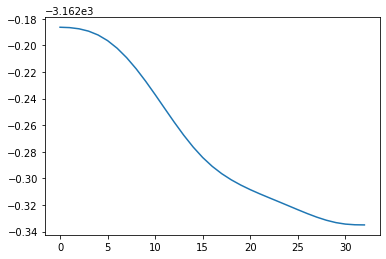

36    107   1.84711e-03   2.03231e-03   1.66192e-03   5.36779e-03   2.62232e-03   1.00e+00   1.230e-01


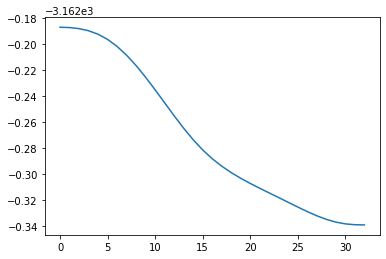

37    107   1.84671e-03   2.01358e-03   1.67983e-03   5.12343e-03   2.54508e-03   1.00e+00   1.212e-01


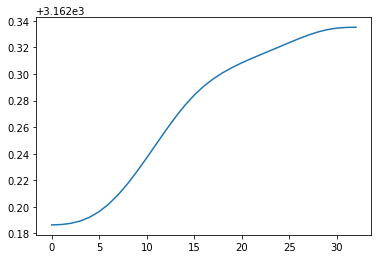

38    107   1.84608e-03   2.02938e-03   1.66278e-03   4.93740e-03   2.49372e-03   1.00e+00   1.200e-01


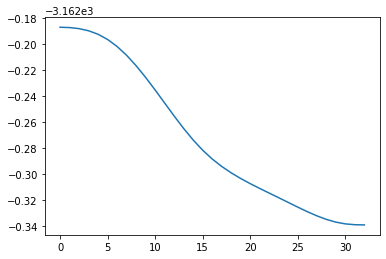

39    107   1.84576e-03   2.01222e-03   1.67930e-03   4.71493e-03   2.42008e-03   1.00e+00   1.182e-01


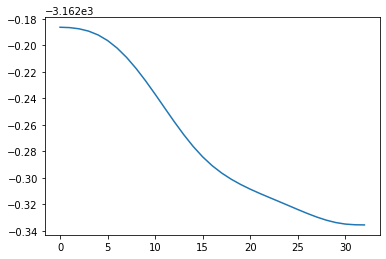

40    107   1.84524e-03   2.02688e-03   1.66361e-03   4.55640e-03   2.37960e-03   1.00e+00   1.172e-01


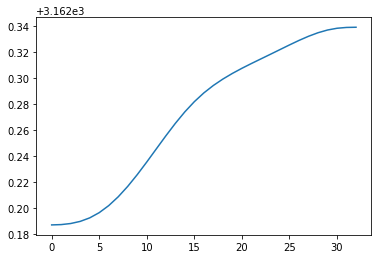

41    107   1.84501e-03   2.01114e-03   1.67887e-03   4.35818e-03   2.31112e-03   1.00e+00   1.155e-01


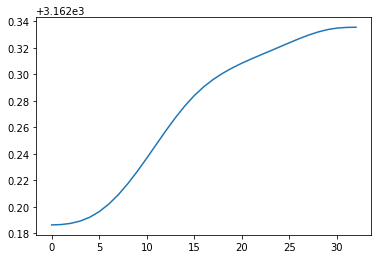

42    107   1.84458e-03   2.02478e-03   1.66438e-03   4.22717e-03   2.28238e-03   1.00e+00   1.148e-01


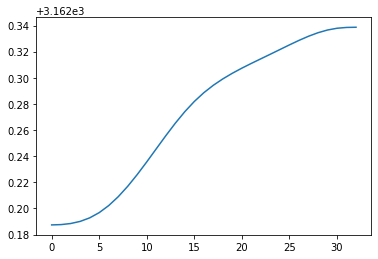

43    107   1.84440e-03   2.01027e-03   1.67853e-03   4.05124e-03   2.21923e-03   1.00e+00   1.132e-01


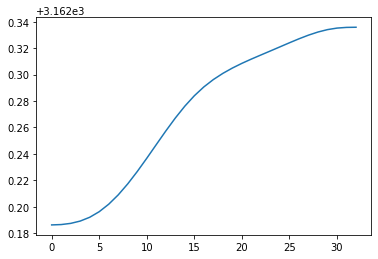

44    107   1.84404e-03   2.02300e-03   1.66509e-03   3.94338e-03   2.19981e-03   1.00e+00   1.127e-01


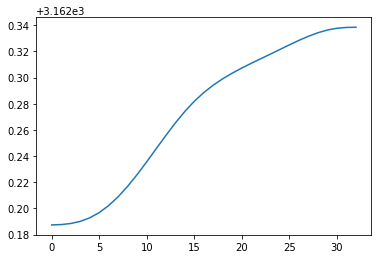

45    107   1.84391e-03   2.00958e-03   1.67824e-03   3.78751e-03   2.14186e-03   1.00e+00   1.112e-01


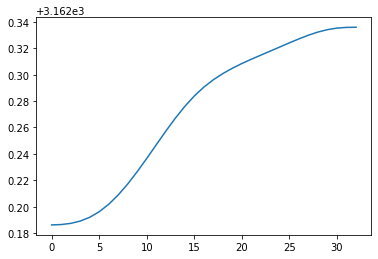

46    107   1.84362e-03   2.02149e-03   1.66574e-03   3.69925e-03   2.12989e-03   1.00e+00   1.109e-01


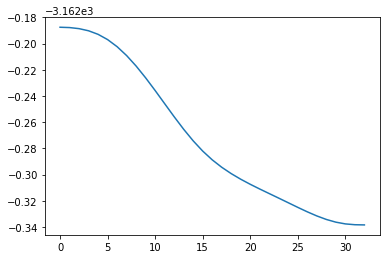

47    107   1.84352e-03   2.00904e-03   1.67800e-03   3.56166e-03   2.07664e-03   1.00e+00   1.095e-01


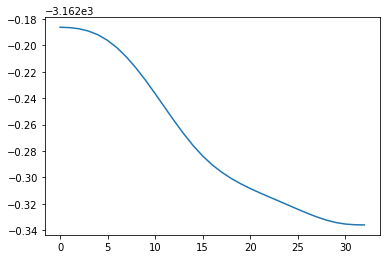

48    107   1.84327e-03   2.02021e-03   1.66633e-03   3.48995e-03   2.07053e-03   1.00e+00   1.093e-01


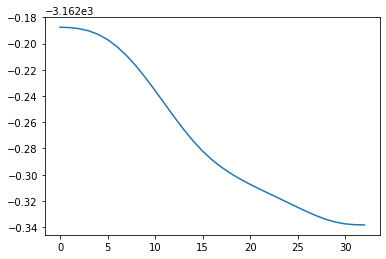

49    107   1.84320e-03   2.00860e-03   1.67780e-03   3.36859e-03   2.02180e-03   1.00e+00   1.080e-01


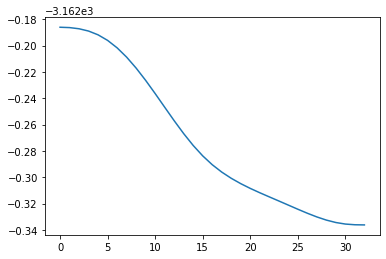

50    107   1.84299e-03   2.01912e-03   1.66686e-03   3.31120e-03   2.02098e-03   1.00e+00   1.080e-01


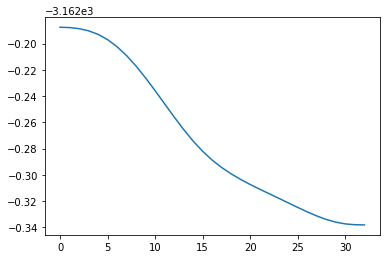

51    107   1.84294e-03   2.00826e-03   1.67763e-03   3.20435e-03   1.97607e-03   1.00e+00   1.068e-01


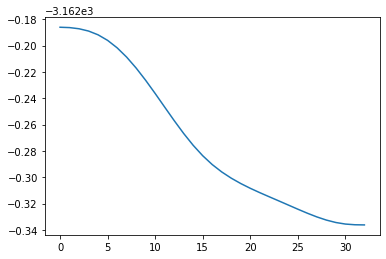

52    107   1.84276e-03   2.01819e-03   1.66734e-03   3.15902e-03   1.97921e-03   1.00e+00   1.069e-01


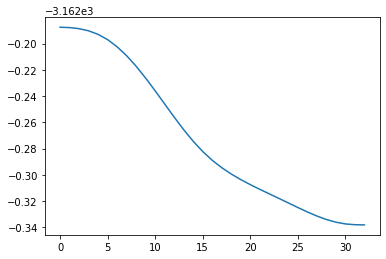

53    107   1.84273e-03   2.00798e-03   1.67748e-03   3.06475e-03   1.93737e-03   1.00e+00   1.057e-01


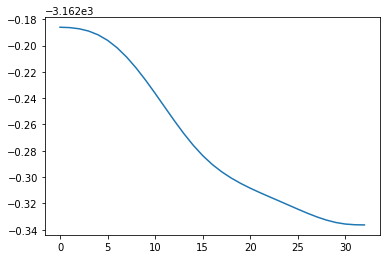

54    107   1.84258e-03   2.01738e-03   1.66778e-03   3.02932e-03   1.94326e-03   1.00e+00   1.059e-01


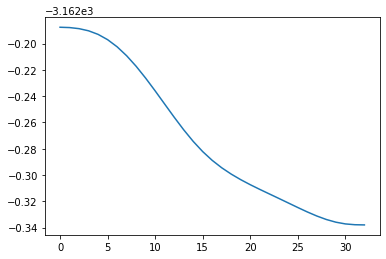

55    107   1.84256e-03   2.00776e-03   1.67736e-03   2.94631e-03   1.90484e-03   1.00e+00   1.049e-01


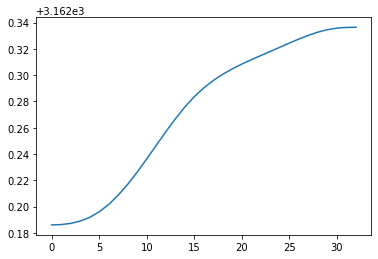

56    107   1.84243e-03   2.01669e-03   1.66817e-03   2.91984e-03   1.91430e-03   1.00e+00   1.051e-01


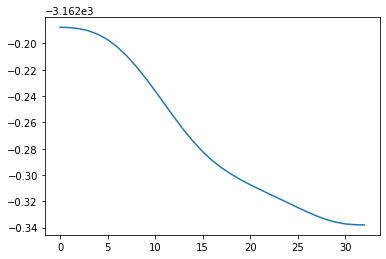

57    107   1.84242e-03   2.00759e-03   1.67725e-03   2.84665e-03   1.87864e-03   1.00e+00   1.041e-01


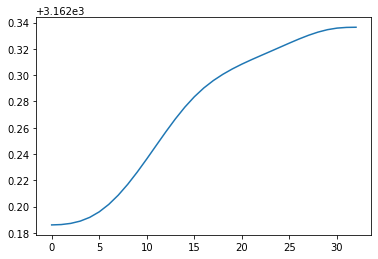

58    107   1.84231e-03   2.01610e-03   1.66852e-03   2.82782e-03   1.89061e-03   1.00e+00   1.045e-01


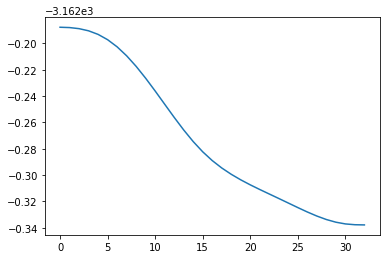

59    107   1.84040e-03   2.00798e-03   1.67281e-03   2.76313e-03   1.85720e-03   5.00e-01   1.035e-01


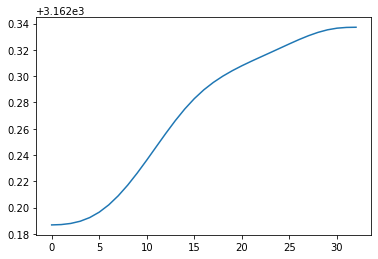

60    110   1.84038e-03   2.00602e-03   1.67474e-03   1.81899e-04   6.87033e-05   1.00e+00   1.991e-02


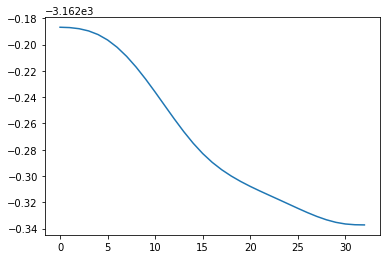

61    110   1.84038e-03   2.00629e-03   1.67447e-03   4.41835e-05   2.56526e-05   1.00e+00   1.217e-02


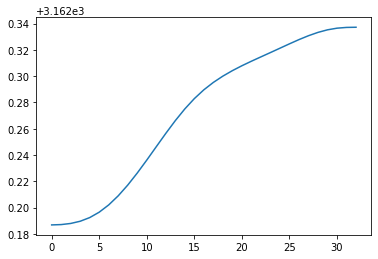

62    107   1.84038e-03   2.00629e-03   1.67448e-03   3.66150e-05   2.47319e-05   1.00e+00   1.195e-02


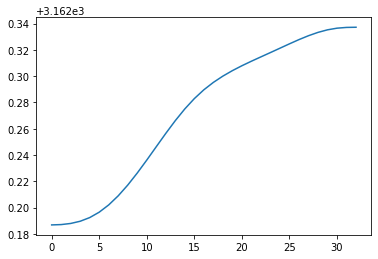

63    107   1.84038e-03   2.00634e-03   1.67443e-03   3.67841e-05   2.45616e-05   1.00e+00   1.191e-02


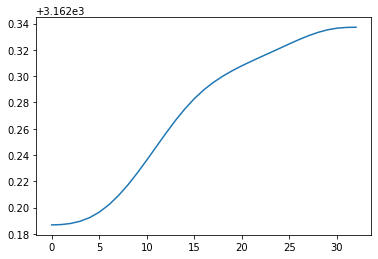

64    107   1.84038e-03   2.00631e-03   1.67446e-03   3.65661e-05   2.44208e-05   1.00e+00   1.187e-02


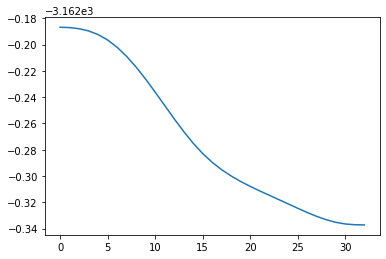

65    107   1.84038e-03   2.00635e-03   1.67442e-03   3.62479e-05   2.42023e-05   1.00e+00   1.182e-02


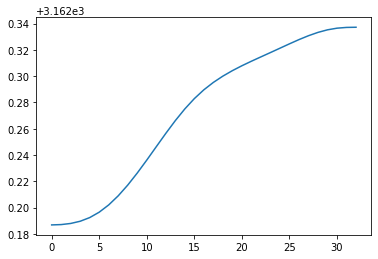

66    107   1.84038e-03   2.00631e-03   1.67445e-03   3.58825e-05   2.40057e-05   1.00e+00   1.177e-02


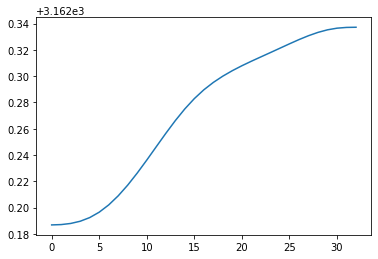

67    107   1.84038e-03   2.00635e-03   1.67442e-03   3.54924e-05   2.38116e-05   1.00e+00   1.172e-02


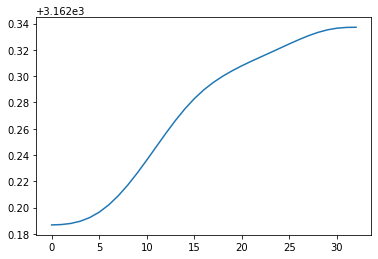

68    107   1.84038e-03   2.00632e-03   1.67445e-03   3.50981e-05   2.35963e-05   1.00e+00   1.167e-02


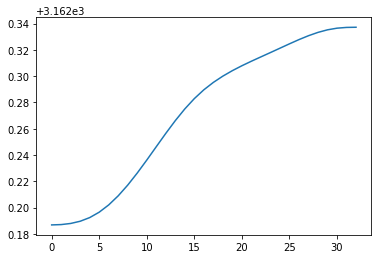

69    107   1.84038e-03   2.00634e-03   1.67442e-03   3.47056e-05   2.34230e-05   1.00e+00   1.163e-02


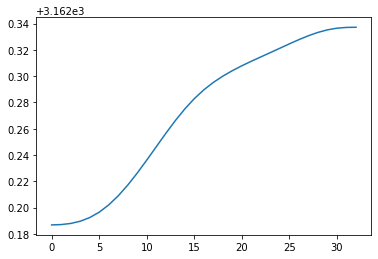

70    107   1.84038e-03   2.00631e-03   1.67445e-03   3.43255e-05   2.32082e-05   1.00e+00   1.157e-02


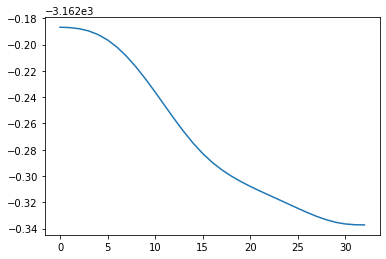

71    107   1.84038e-03   2.00634e-03   1.67443e-03   3.39587e-05   2.30529e-05   1.00e+00   1.154e-02


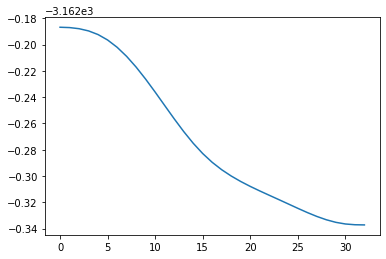

72    107   1.84038e-03   2.00631e-03   1.67445e-03   3.36115e-05   2.28503e-05   1.00e+00   1.148e-02


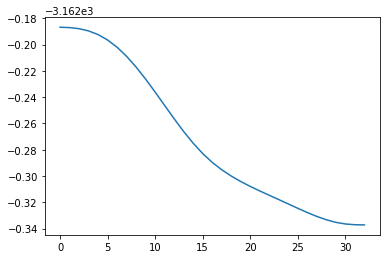

73    107   1.84038e-03   2.00633e-03   1.67443e-03   3.32824e-05   2.27120e-05   1.00e+00   1.145e-02


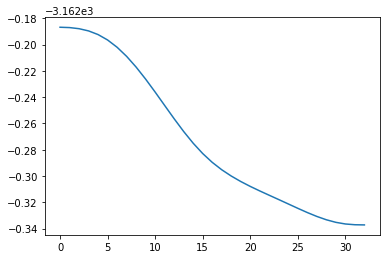

74    106   1.84038e-03   2.00632e-03   1.67444e-03   3.28396e-05   2.25287e-05   1.00e+00   1.140e-02


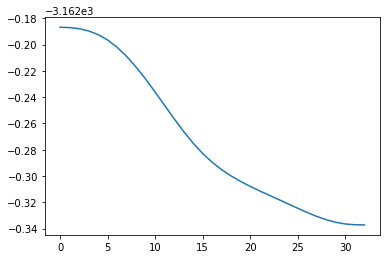

75    106   1.84038e-03   2.00632e-03   1.67444e-03   3.28364e-05   2.24398e-05   1.00e+00   1.138e-02


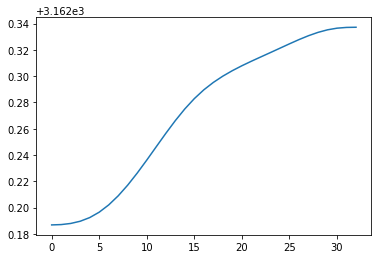

76    106   1.84038e-03   2.00632e-03   1.67444e-03   3.27692e-05   2.23121e-05   1.00e+00   1.135e-02


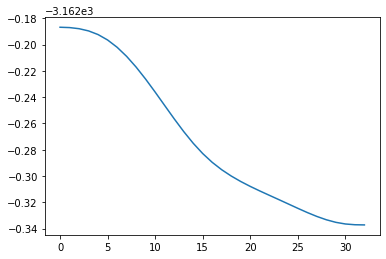

77    106   1.84038e-03   2.00632e-03   1.67444e-03   3.26643e-05   2.22887e-05   1.00e+00   1.134e-02


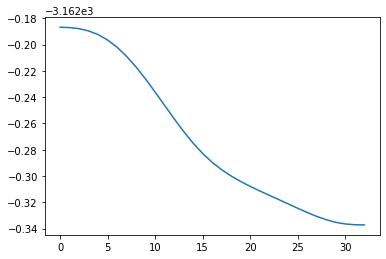

78    106   1.84038e-03   2.00632e-03   1.67445e-03   3.25656e-05   2.21979e-05   1.00e+00   1.132e-02


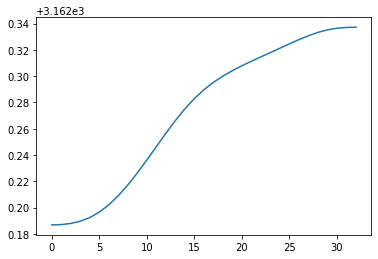

79    106   1.84038e-03   2.00632e-03   1.67444e-03   3.24582e-05   2.21761e-05   1.00e+00   1.131e-02


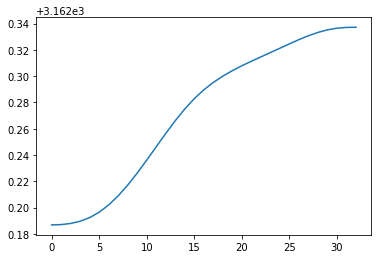

80    106   1.84038e-03   2.00632e-03   1.67445e-03   3.23577e-05   2.20936e-05   1.00e+00   1.129e-02


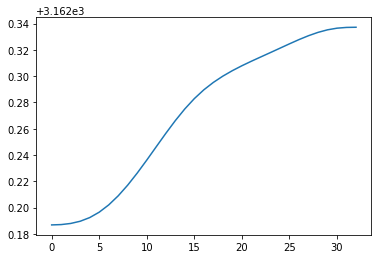

81    106   1.84038e-03   2.00632e-03   1.67445e-03   3.22540e-05   2.20715e-05   1.00e+00   1.129e-02


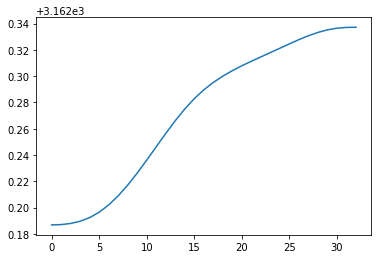

82    106   1.84038e-03   2.00632e-03   1.67445e-03   3.21559e-05   2.19928e-05   1.00e+00   1.127e-02


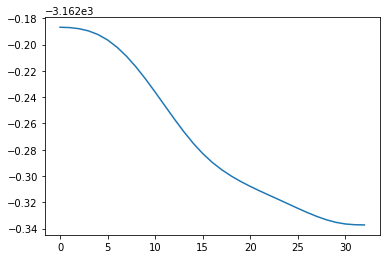

83    106   1.84038e-03   2.00632e-03   1.67445e-03   3.20560e-05   2.19707e-05   1.00e+00   1.126e-02


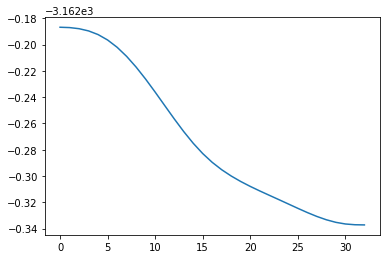

84    106   1.84038e-03   2.00631e-03   1.67445e-03   3.19610e-05   2.18945e-05   1.00e+00   1.124e-02


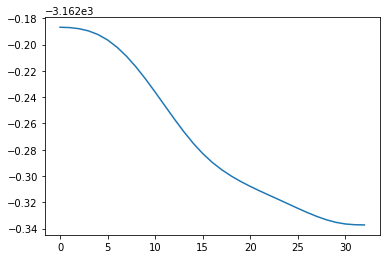

85    106   1.84038e-03   2.00632e-03   1.67445e-03   3.18646e-05   2.18726e-05   1.00e+00   1.124e-02


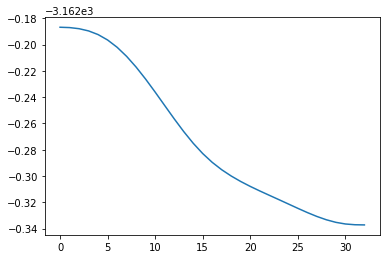

86    106   1.84038e-03   2.00631e-03   1.67445e-03   3.17726e-05   2.17984e-05   1.00e+00   1.122e-02


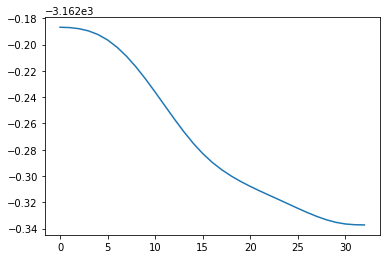

87    106   1.84038e-03   2.00632e-03   1.67445e-03   3.16792e-05   2.17768e-05   1.00e+00   1.121e-02


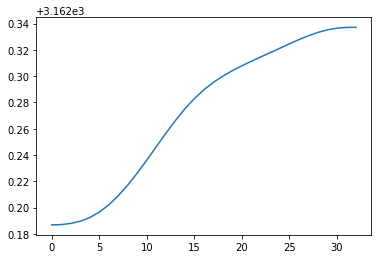

88    106   1.84038e-03   2.00631e-03   1.67445e-03   3.15902e-05   2.17040e-05   1.00e+00   1.119e-02


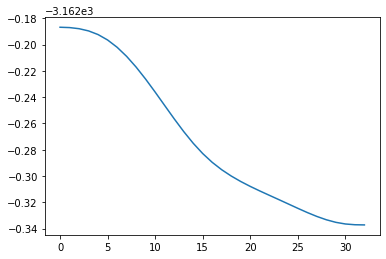

89    106   1.84038e-03   2.00631e-03   1.67445e-03   3.14996e-05   2.16827e-05   1.00e+00   1.119e-02


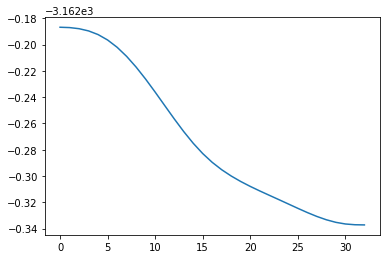

90    106   1.84038e-03   2.00631e-03   1.67445e-03   3.14132e-05   2.16113e-05   1.00e+00   1.117e-02


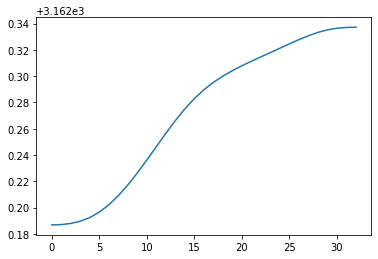

91    106   1.84038e-03   2.00631e-03   1.67445e-03   3.13251e-05   2.15901e-05   1.00e+00   1.116e-02


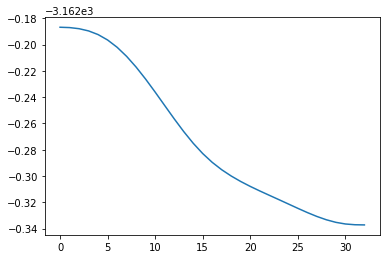

92    106   1.84038e-03   2.00631e-03   1.67445e-03   3.12411e-05   2.15199e-05   1.00e+00   1.114e-02


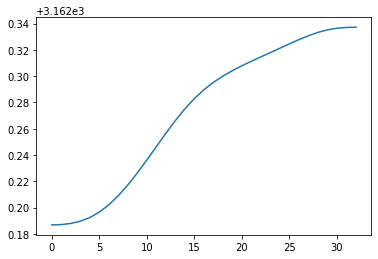

93    106   1.84038e-03   2.00631e-03   1.67445e-03   3.11554e-05   2.14986e-05   1.00e+00   1.114e-02


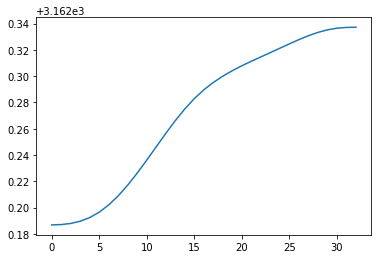

94    106   1.84038e-03   2.00631e-03   1.67445e-03   3.10736e-05   2.14296e-05   1.00e+00   1.112e-02


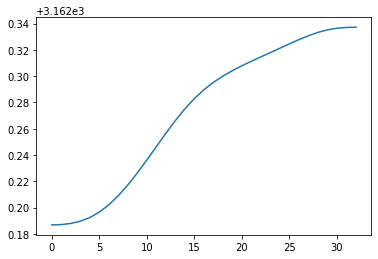

95    106   1.84038e-03   2.00631e-03   1.67445e-03   3.09900e-05   2.14081e-05   1.00e+00   1.112e-02


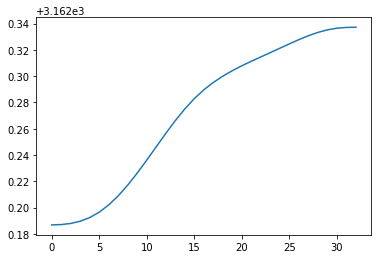

96    106   1.84038e-03   2.00631e-03   1.67445e-03   3.09103e-05   2.13401e-05   1.00e+00   1.110e-02


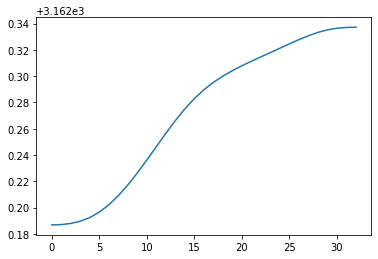

97    106   1.84038e-03   2.00631e-03   1.67445e-03   3.08286e-05   2.13183e-05   1.00e+00   1.109e-02


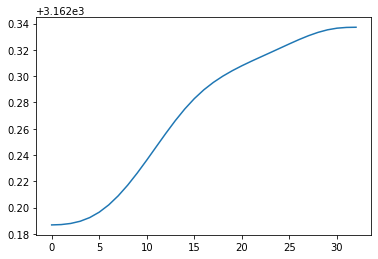

98    106   1.84038e-03   2.00631e-03   1.67445e-03   3.07508e-05   2.12512e-05   1.00e+00   1.108e-02


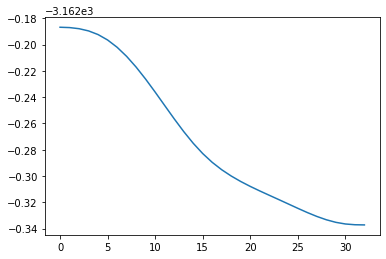

99    106   1.84038e-03   2.00631e-03   1.67445e-03   3.06708e-05   2.12289e-05   1.00e+00   1.107e-02
Newton's method did not converge in  100  iterations


In [15]:
tol = 1e-11
c = 1e-4
maxiter=100
m, u1, u2 = run.opt_loop(m, tol, c, maxiter, save_opt_log=False, plot_opt_step=False, plot_eigval=True)

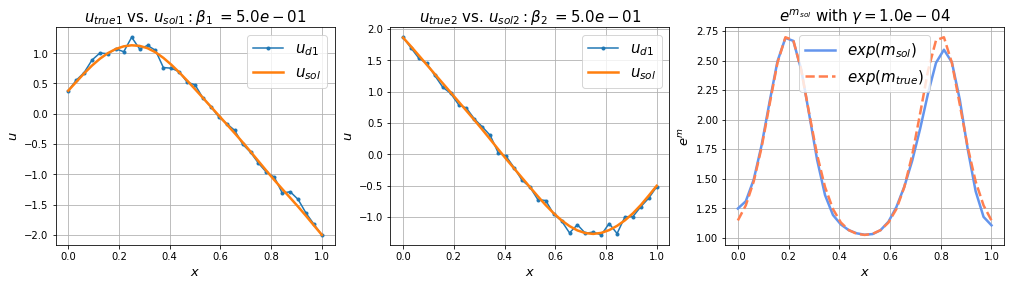

In [16]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

ax[0].plot(x, run.ud1.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
ax[0].plot(x, u1.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$u$', fontsize=13)
ax[0].set_title(r'$u_{true1}$ vs. $u_{sol1}: \beta_1$' + f' $ = {beta1:1.1e}$', fontsize=15)
ax[0].legend(prop={'size':15})

ax[1].plot(x, run.ud2.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
ax[1].plot(x, u2.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$u$', fontsize=13)
ax[1].set_title(r'$u_{true2}$ vs. $u_{sol2}: \beta_2$' + f' $ = {beta2:1.1e}$', fontsize=15)
ax[1].legend(prop={'size':15})

text = ax[2].yaxis.get_offset_text()
text.set_fontsize(8)
ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
ax[2].plot(x, np.exp(m_true.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[2].grid('on')
ax[2].set_xlabel(r'$x$', fontsize=13)
ax[2].set_ylabel(r'$e^m$', fontsize=13)
ax[2].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {run.gamma:1.1e}$', fontsize=15)
ax[2].legend(prop={'size':15})

# plt.savefig(f'./log/img/dual_helm_synth_{beta1:1.1f}_{beta2:1.1f}.eps', format='eps',dpi=250)
plt.show()

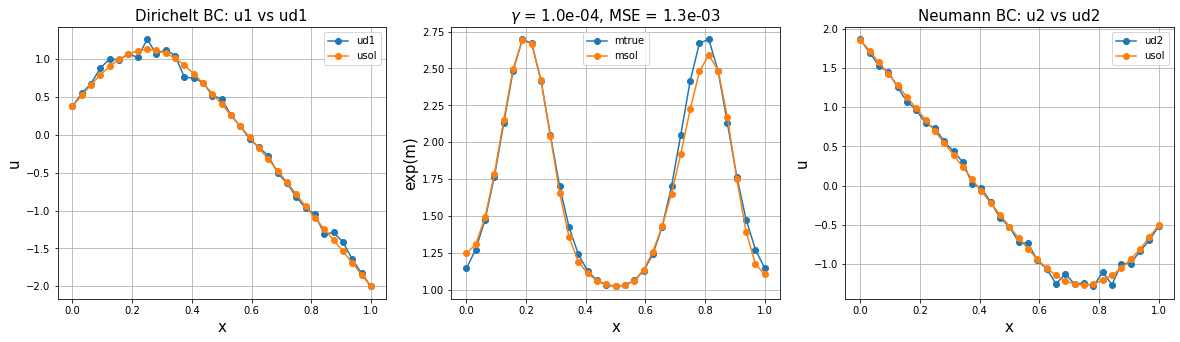

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5)) 
ax[0].plot(x,run.ud1.compute_vertex_values(), 'o-', label='ud1')
ax[0].plot(x,u1.compute_vertex_values(), 'o-', label='usol')
ax[0].set_xlabel('x', fontsize=15)
ax[0].set_ylabel('u', fontsize=15)
ax[0].set_title('Dirichelt BC: u1 vs ud1', fontsize=15)
ax[0].grid()
ax[0].legend()

mse = (np.square(m_true.compute_vertex_values() - m.compute_vertex_values())).mean()
ax[1].plot(x,np.exp(m_true.compute_vertex_values()), 'o-', label='mtrue')
ax[1].plot(x,np.exp(m.compute_vertex_values()), 'o-', label='msol')
ax[1].set_xlabel('x', fontsize=15)
ax[1].set_ylabel('exp(m)', fontsize=15)
ax[1].set_title(f'$\gamma$ = {run.gamma:1.1e}, MSE = {mse:1.1e}', fontsize=15)
ax[1].grid()
ax[1].legend()

ax[2].plot(x,run.ud2.compute_vertex_values(), 'o-', label='ud2')
ax[2].plot(x,u2.compute_vertex_values(), 'o-', label='usol')
ax[2].set_xlabel('x', fontsize=15)
ax[2].set_ylabel('u', fontsize=15)
ax[2].set_title('Neumann BC: u2 vs ud2', fontsize=15)
ax[2].grid()
ax[2].legend()

# plt.savefig('./log/img/dual_helm_synth.eps', format='eps', bbox_inches='tight')

0.38276315817937345


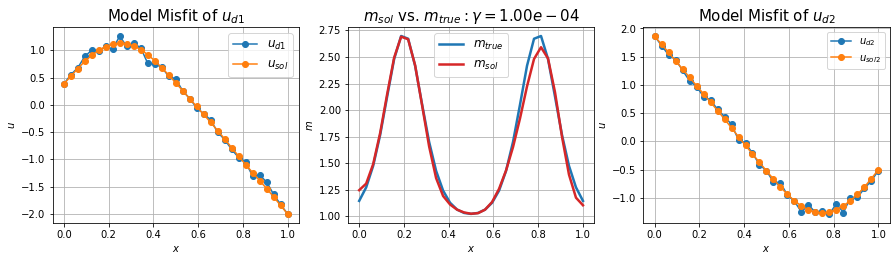

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3.6)) 
ax[0].plot(x,run.ud1.compute_vertex_values(), 'o-', label=r'$u_{d1}$')
ax[0].plot(x,u1.compute_vertex_values(), 'o-', label=r'$u_{sol}$')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$u$')
ax[0].set_title(r'Model Misfit of $u_{d1}$', fontsize=15)
ax[0].grid()
ax[0].legend(fontsize=12)

mse = (np.square(m_true.compute_vertex_values() - m.compute_vertex_values())).mean()
ax[1].plot(x,np.exp(m_true.compute_vertex_values()), '-', label=r'$m_{true}$', linewidth=2.5,color = 'tab:blue')
ax[1].plot(x,np.exp(m.compute_vertex_values()), '-', label=r'$m_{sol}$', linewidth=2.5,color = 'tab:red')
# ax[1].set_title(f'gamma = {gamma[kappa_min_ind]:.3e}')
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$m$')
ax[1].set_title(r'$m_{sol}$ vs. $m_{true}$'+f'$: \gamma = {run.gamma:1.2e}$', fontsize=15)
ax[1].grid()
ax[1].legend(fontsize=12)

ax[2].plot(x,run.ud2.compute_vertex_values(), 'o-', label=r'$u_{d2}$')
ax[2].plot(x,u2.compute_vertex_values(), 'o-', label=r'$u_{sol2}$')
ax[2].set_xlabel(r'$x$')
ax[2].set_ylabel(r'$u$')
ax[2].set_title(r'Model Misfit of $u_{d2}$', fontsize=15)
ax[2].grid()
ax[2].legend()

print(np.linalg.norm(np.exp(m_true.compute_vertex_values()) - np.exp(m.compute_vertex_values())))
# plt.savefig('./log/img/dual_helm_synth.png', bbox_inches='tight',dpi=300)
# plt.savefig('./log/img/dual_helm_synth.eps', format='eps', bbox_inches='tight',dpi=300)

### EigenVal

24
26


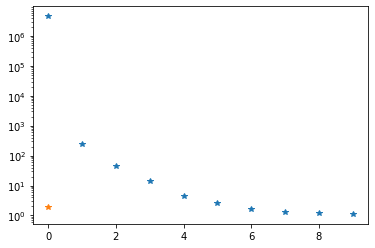

In [23]:
k = run.nx
lmbda, evecs = run.eigenvalue_request(m, p=20)

print(sum(lmbda >= 1.0))
print(sum(run.lmbda >= 1.0))

idx = 10
plt.semilogy(lmbda[:idx], '*')
plt.plot(run.lmbda[idx], '*')
dual_eig = lmbda.copy()

In [20]:
evecs[0].get_local().shape

(33,)

Text(0.5, 1.0, 'Eigenvector $v0$')

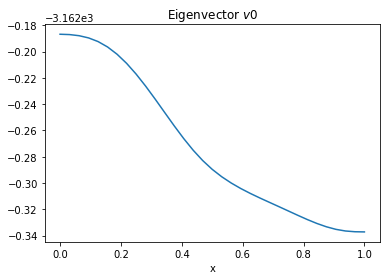

In [24]:
idx = 0
plt.plot(x,evecs[idx])
plt.xlabel('x')
plt.title(f'Eigenvector $v{idx}$')
# plt.savefig(f'./log/img/eigvec{idx}.eps', format='eps', bbox_inches='tight',dpi=300)
# plt.savefig(f'./log/img/eigvec{idx}.eps', format='eps',dpi=250)

In [37]:
test1 = np.array([1.2123])
print(f'{test1.item()}')

1.2123
